# NYPD Fare Evasion Enforcement's Disparate Impact
Leena Kahlon, Dylan Fosgett, Woo Hyuk Chang and Rebecca Dorn
University of California, Santa Cruz, Fall 2019

<img src="https://pbs.twimg.com/media/EJAwu4gWsAoPKwL?format=jpg&name=medium">

*Image from Twitter's @DecolonizeThisPlace*

## Introduction
***
Imagine your loan application has just been rejected by your bank. You ask them why, and they respond that the neighborhood you live in scored poorly for likelihood to pay the loan back. For some reason this bank has the algorithm they use online. You look into it a bit more, and you realize that though the bank does not use race as a feature, those who live in predominantly African American neighborhoods are almost three times as likely to be denied a loan. Disparate impact refers to "when policies, practices, rules or other systems that appear to be neutral result in a disproportionate impact on a protected group". No one in the bank sat down and say "hey, I'm going to create a fairly racist predictor!". But, the rules that the bank goes by dispraportionately impact African Americans. Situations like these are all too common in the United States, and they must be addressed.

On October 28, 2019, a video of around ten police officers tackling and pulling guns on a black teen for evading the \$2.75 subway fare in New York City went viral. Communities were enraged to see this fierceley violent attack on a teen of color over such a small fare. A few months before, the MTA calculated that they were losing millions annually due to those who evade paying the transit fare. The MTA decided to deploy 500 new officers to watch for turnstile hoppers, in hopes of losing less money. While in theory this plan makes sense, we can't help but wonder. What kind of disparate impact against communities of color is happening? What about against lower income communities?


## Setup: Installing Necessary Libraries
```pip install matplotlib
pip install numpy
pip install pandas
pip install geopandas
pip install beautifulsoup4
pip install seaborn
pip install twitter
pip install nltk```

Cooresponding files can be found on git: https://github.com/rebdorn/fare_evasion

## Project
***
We organize our project into distinct portions
1. Web Scraping
2. Data Wrangling
3. Data Visualization

Our goal is to create an easy-to-use visualization to answer the following research questions:
1. How has fare evasion enforcement in New York City changed in recent years?
2. What subway stations have an outstanding number of recent police sightings? What are the demographics around these stations?
3. What are the fare evasione enforcement trends around stations with outstanding numbers of recent police sightings?
4. What is the overlap between stations with more police sightings and stations with more fare evasion enforcement?

# Web Scraping
***
To get recent police sightings, we scrape twitter account @unfarenyc. This is an account where people send information about police sightings at subway stations, and they post the number of cops and which subway station. We scrape the twitter account these sightings using nltk and bear's python twitter wrapper. Note that to run this code on your account, you must posess a secret key given by the Twitter API.

We begin by running some import statements. Make sure to run this cell, or else the code won't work!

In [1]:
# Some import statements to make our code run
from itertools import permutations
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import twitter
import nltk

**Scraping the Twitter API:** We use bare's Python wrapper for the twitter API to make our life easier. The operations we do occur as follows:
- Connect to the Twitter API using our given keys. (Note: a key is not provided in this demo, make sure to plug your own key into git.ignore before running thic cell!)
- Get the entirety of @UnfareNYC's timeline. The function "GetUserTimeine" requires we specify the number of tweets to request, and the maximum is 200. Because of this, we need to recursively find the earliest tweet out of the 200 we get, and use that as an end point for the 200 tweets beforehand.
- The twitter API gives us a hefty amount of information. So, store only our most desired information in our dataframe: ID, User, created_at and text.

In [2]:
CONSUMER_KEY = '0ift2jAgEYQrWs8OP1f9TjRQ1'
CONSUMER_SECRET = 'qq9jNTaS3cG9wVc2Hxij3M0GuhAy72wNzFnBc9y1ejp2xh5dg4'
ACCESS_TOKEN_KEY = '144353594-pUtB5UxLeZHwZxJH4vPtFQMXAvgyQKTyvDanafog'
ACCESS_TOKEN_SECRET = 'TvGH6dRf2J0PTKgBiSwWJ022j25PNBBaYUZQYWML1bDok'

# connect to twitter API with our given user credentials
api = twitter.Api(consumer_key = CONSUMER_KEY,
                      consumer_secret = CONSUMER_SECRET,
                      access_token_key = ACCESS_TOKEN_KEY,
                      access_token_secret = ACCESS_TOKEN_SECRET)

In [3]:
# Scrape @unfarenyc's twitter timeline
statuses_list = api.GetUserTimeline(count=200,screen_name='unfarenyc') # Load @unfarenyc's timeline

# To get earlier tweets we continuously find the minimum and get the 200 previous
earliest_tweet = min(statuses_list, key=lambda x: x.id).id # Find the last tweet we were allowed to get
while True: # While there are more tweet to get
    nexttweets = api.GetUserTimeline(screen_name='unfarenyc', max_id=earliest_tweet, count=200)
    new_earliest = min(nexttweets, key=lambda x: x.id).id
    if not nexttweets or new_earliest == earliest_tweet:
        break
    else:
        earliest_tweet = new_earliest
        statuses_list += nexttweets

In [4]:
# Store the desired information into a dataframe
tweets = []
for s in statuses_list:
    tweets.append([s.id,s.user.screen_name,s.created_at,s.text,s.retweet_count])
tweetsdf = pd.DataFrame(tweets,columns=['ID','user','created_at','text','retweets'])

We define two functions. One to process subway station names such that they are all lowercase, we separate "2nd" to "2" and "nd" (Same with formats of 1st, 17th) and change some common phrases to be short and don't include vowels. Secoond function is to change unigrams to match station names-- we remove some specific punctuation and change park -> pk, etc.

In [47]:
# Our NLP protocol for getting unigrams into a usable form
def process_unigram(unigram):
    if unigram[0].isdigit() & unigram.endswith('st'): # Are we of form "1"st?
        unigram = unigram[:-2] # Shorten unigram to only that street number
    elif unigram[0].isdigit() & unigram.endswith('nd'): # Are we of form "2"nd?
        unigram = unigram[:-2] # Shorten unigram to just that number
    elif unigram[0].isdigit() and unigram.endswith('th'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram[0].isdigit() and unigram.endswith('rd'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram == 'park': # If this unigram reads 'park'
        unigram = 'pk' # Shorten it to match our station names
    elif unigram == 'parkway': # If this unigram reads "parkway"
        unigram = 'pkwy' # Shorten it to match our station names
    elif unigram == 'heights': # If this unigram reads "heights"
        unigram = 'hts' # Shorted it to match our station names
    elif unigram == 'ave':
        unigram = 'av'
    elif unigram == 'place':
        unigram = 'pl'
    return unigram

# Our NLP protocol for processing subway names (removing punct, etc.)
def process_stations(df_col):
    processed_tweets = df_col.str.replace(" - "," ")
    processed_tweets = processed_tweets.str.replace("-"," ")
    processed_tweets = processed_tweets.str.replace("/"," ")
    processed_tweets = processed_tweets.str.replace(".","")
    processed_tweets = processed_tweets.str.replace("'","")
    processed_tweets = processed_tweets.str.lower()
    processed_tweets = processed_tweets.str.replace("ave","av")
    processed_tweets = processed_tweets.str.replace("street","st")
    processed_tweets = processed_tweets.str.replace("square","sq")
    processed_tweets = processed_tweets.str.replace("place", "pl")
    processed_tweets = processed_tweets.str.replace("heights","hts")
    processed_tweets = processed_tweets.str.replace("park","pk")
    processed_tweets = processed_tweets.str.replace("jay st metrotech","jay st")
    return processed_tweets

Process the subway names, create a list of subway station names to later check tweets

In [48]:
# Read the CSV file of Subway Station names and process the names
stations = pd.read_csv("Stations.csv")

# Process the station names, convert to list for easy searching
station_names = list(process_stations(stations['Stop Name']))

# Process the tweets such that it sepearates hyphens, we process unigrams more later.
processed_tweets = process_stations(tweetsdf['text'])

# Add new empty column to tweetsdf to store station names
tweetsdf['station_referral'] = np.nan

Create column of datetime objects

In [49]:
from datetime import date

# A simple mapping of the first 3 letters of months to their numerical representation
month_number = { 'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4,
                'May': 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8,
                'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

# Create a new column in the tweets dataframe for our datetime objects and populate
tweetsdf['created_at_datetime'] = np.nan
for k, instance in enumerate(tweetsdf['created_at']): # for each tweet's creation time/day
    for i, chunk in enumerate(instance.split(" ")): # parse through the datetime, split by space
        if i == 1:
            this_month = month_number[chunk]
        elif i == 2:
            this_day = int(chunk)
        elif i == 5:
            this_year = int(chunk)
    tweet_datetime = date(year = this_year, month = this_month, day = this_day)
    tweetsdf.loc[k,'created_at_datetime'] = tweet_datetime

Loop through tweets, check fourgram -> unigram if this is a station name (Bigger name first helps ensure we get right station)

In [50]:
# Loop through each tokened tweet and look for the subway station

for i, row in enumerate(processed_tweets.apply(nltk.tokenize.word_tokenize)):
    found = 0 # At the beginning of each tweet, reset bool found
    
    for fourgram in nltk.ngrams(row,4): # Check each combo of 4 tokens in tweet
        for unigram in fourgram: # Process the individual unigrams in the fourgram
            unigram = process_unigram(unigram)
        one, two, three, four = fourgram # Unpack fourgram to permute versions of tuple
        for ordering in permutations([one, two, three, four]): # For each possible ordering of these unigrams
            perm_one, perm_two, perm_three, perm_four = ordering # Unpack this permutation
            if perm_one+" "+perm_two+" "+perm_three+" "+perm_four in station_names[:]: # If this permutation is a station name
                tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three+" "+perm_four # Put the data in our dataframe
                found = 1 # Signal that for this tweet we have found the station
                break # Break out of the loop!
    
    if found != 1: # If we have checked all fourgrams and did not find the subway station
        for trigram in nltk.trigrams(row):
            for unigram in trigram:
                unigram = process_unigram(unigram)
            one, two, three = trigram
            for ordering in permutations([one, two, three]):
                perm_one, perm_two, perm_three = ordering
                if perm_one+" "+perm_two+" "+perm_three in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three
                    found = 1
                    break
    if found != 1:
        for bigram in nltk.bigrams(row):
            for unigram in bigram:
                unigram = process_unigram(unigram)
            one, two = bigram
            for ordering in permutations([one, two]):
                perm_one, perm_two = ordering
                if perm_one+" "+perm_two in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two
                    found = 1
                    break         
    if found != 1:
        for unigram in row:
            unigram = process_unigram(unigram)
            if unigram+" st" in station_names[:]:
                tweetsdf.loc[i,'station_referral'] = unigram+" st"
                found = 1
                break
            elif unigram+" av" in station_names[:]:
                tweetsdf.loc[i,'station_referral'] = unigram+" av"
                found = 1
                break
            elif unigram in station_names[:]:
                tweetsdf.loc[i,'station_referral'] = unigram
                found = 1
                break           

In [51]:
# for seeing things without rerunning things

text station_referral
0     RT @OKdotGLASS: @unfarenyc 2 cops at Canarsie ...        graham av
1     2 cops in uniform at 72nd st 1/2/3 station (1:...             2 av
2     RT @Hurowittty: @unfarenyc 3 cops out of sight...             3 av
3     RT @revafisheye: @unfarenyc 3 or 4 uniforms at...             3 av
4     RT @gabekelley: @unfarenyc six cops on manhatt...     borough hall
...                                                 ...              ...
2071     6 cops doing bag checks at Fulton Center (8am)             6 av
2072  2 cops at the Brook Ave station, behind the tu...         brook av
2073  Two cops on Brooklyn-bound side at the Nostran...      nostrand av
2074  Two cops at Jay St (Willoughby St entrance) be...           jay st
2075    Cops at 53rd street N/R in Sunset Park (5:05pm)            53 st

[2076 rows x 2 columns]

For our project, we map out 24 specific stations such that each transit district has one high count station and one low count station. Let's take a look at how we chose Transit district 2-- feel free to do the same for the other transit districts via how we did this one!

/Users/beccadorn/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


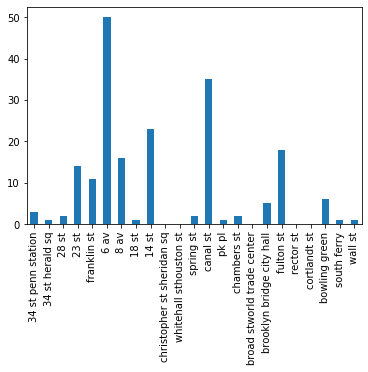

In [9]:
# Store a list of the processed versions of all stations in transit district 2
transit_district_2_stations = ['34 st penn station', '34 st herald sq', '28 st', '23 st', 'franklin st',
                               '6 av', '8 av', '18 st', '14 st', 'christopher st sheridan sq', 'whitehall st'
                               'houston st', 'spring st', 'canal st', 'pk pl', 'chambers st', 'broad st'
                               'world trade center', 'brooklyn bridge city hall', 'fulton st', 'rector st',
                               'cortlandt st', 'bowling green', 'south ferry', 'wall st']

# Get a counter of sightings for all stations (then we'll narrow it down to the desired stations)
station_referral_counts = tweetsdf['station_referral'].value_counts()
transit_district_2_sightings = station_referral_counts[transit_district_2_stations]
transit_district_2_sightings.plot.bar()


We take a look at the 3 highest counted stations 6 av, canal st and 14 st. We look at their average ridership.

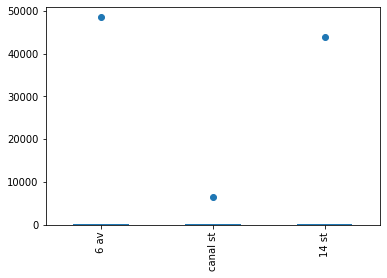

In [10]:
# Let's take a better look at 3 stations: 6 av, canal st and 14 st
transit_district_highest = ['6 av', 'canal st', '14 st']
avg_weekday_ridership_2018 = [48508, 6410, 44031]
station_referral_counts[transit_district_highest].plot.bar()
plt.plot(avg_weekday_ridership_2018,'o')

We now do a few last things: bin a station's tweets by-week, get the average number of police station sightings per-week, and create visualizations of the two for the 24 stations we've chosen to focus on.

In [11]:
# create a series of data ranges we check (Every sunday since its been created)
weekly_bins = pd.date_range(start = '2019-08-04', end = '2019-11-30',freq = 'W-SUN')

# Plot average sightings per week
averagecount_array = [np.nan] * len(weekly_bins)
for i, week in enumerate(weekly_bins):
    daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
    view = np.where((daysofweek[0] >= tweetsdf['created_at_datetime']) & (tweetsdf['created_at_datetime'] <= daysofweek[6]), 1, 0)
    averagecount_array[i] = np.count_nonzero(view)

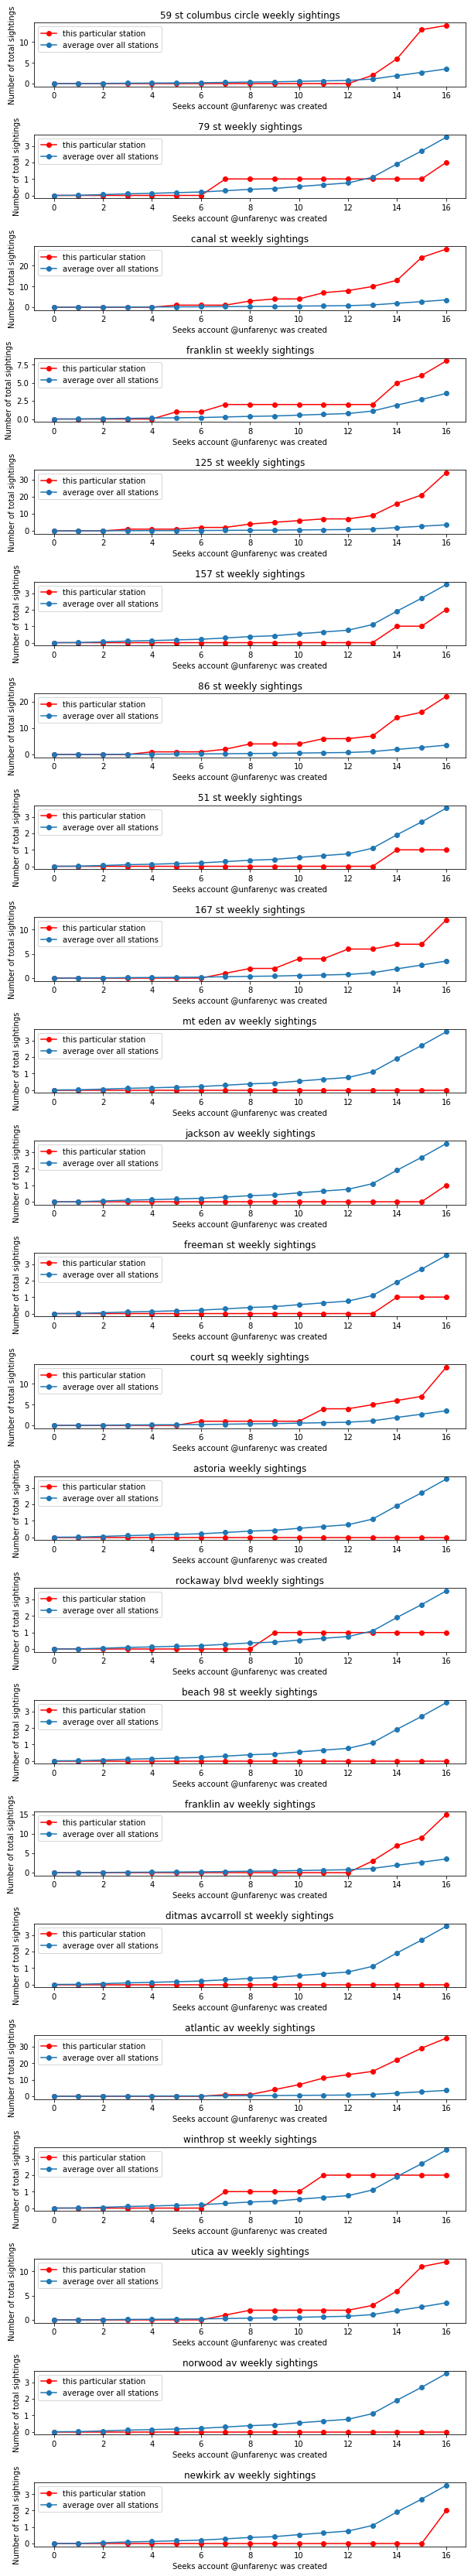

In [12]:
# Function to easily get weekly police counts of a station
def weeklycounts_fromstation(station_name):
    # Get the tweets about our station name
    station_tweets = tweetsdf.loc[tweetsdf['station_referral'] == station_name]
    count_array = [np.nan] * int(len(weekly_bins))
    for i, week in enumerate(weekly_bins):
        daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
        view = np.where((daysofweek[0] >= station_tweets['created_at_datetime']) & (station_tweets['created_at_datetime'] <= daysofweek[6]), 1, 0)
        count_array[i] = np.count_nonzero(view)
    return count_array 

# Get average number of police sightings
average_plot = []
for i, item in enumerate(averagecount_array):
    average_plot.append(averagecount_array[i] / len(station_names))

chosen_stations = ['59 st columbus circle', '79 st', 'canal st', 'franklin st', '125 st',
                  '157 st', '86 st', '51 st', '167 st', 'mt eden av', 'jackson av', 'freeman st',
                  'court sq', 'astoria', 'rockaway blvd', 'beach 98 st', 'franklin av', 'ditmas av'
                  'carroll st', 'atlantic av', 'winthrop st', 'utica av', 'norwood av', 'newkirk av']

fig, axes = plt.subplots(len(chosen_stations),figsize = (10,60))
plt.subplots_adjust(hspace = 0.75)
for i, station in enumerate(chosen_stations):
    count_array = weeklycounts_fromstation(station)
    axes[i].plot(count_array,'-or', label = 'this particular station')
    axes[i].plot(average_plot, '-o', label = 'average over all stations')
    axes[i].set_title(station+" weekly sightings")
    axes[i].set_xlabel("Seeks account @unfarenyc was created")
    axes[i].set_ylabel("Number of total sightings")
    axes[i].legend(loc='best')


## Data Wrangling
***
We further split our data wrangling into three parts:
1. Wrangling at the Community District level
2. Wrangling at the Transit District level

### Wrangling at the Community District level

In [13]:
from pandas import Series, DataFrame

district_demo = pd.read_csv('sf1_dp_cd_demoprofile.csv')
district_demo

Table SF1-DP  CD:  Demographic Profile - New York City Community Districts  \
0                                         2000 and 2010                           
1                                                   NaN                           
2                                         New York City                           
3                                                   NaN                           
4                                                   NaN                           
...                                                 ...                           
4374                                                NaN                           
4375                                                NaN                           
4376                                                NaN                           
4377                                                NaN                           
4378                                                NaN                           

                  Unnamed: 1         Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                        NaN                NaN        NaN        NaN   
1                        NaN                NaN        NaN        NaN   
2                        NaN                NaN        NaN        NaN   
3                        NaN                NaN        NaN        NaN   
4                        NaN                NaN        NaN        NaN   
...                      ...                ...        ...        ...   
4374  By Age of Householder:                NaN        NaN        NaN   
4375                     NaN     15 to 24 years        NaN        NaN   
4376                     NaN     25 to 44 years        NaN        NaN   
4377                     NaN     45 to 64 years        NaN        NaN   
4378                     NaN  65 years and over        NaN        NaN   

     Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8        Unnamed: 9 Unnamed: 10  
0           NaN        NaN        NaN        NaN               NaN         NaN  
1           NaN        NaN        NaN        NaN               NaN         NaN  
2          2000        NaN       2010        NaN  Change 2000-2010         NaN  
3        Number    Percent     Number    Percent            Number     Percent  
4           NaN        NaN        NaN        NaN               NaN         NaN  
...         ...        ...        ...        ...               ...         ...  
4374        NaN        NaN        NaN        NaN               NaN         NaN  
4375        804        1.5        691        1.2              -113       -14.1  
4376     21,365       40.2     17,963       31.4            -3,402       -15.9  
4377     21,161       39.8     25,713       44.9             4,552        21.5  
4378      9,810       18.5     12,883       22.5             3,073        31.3  

[4379 rows x 11 columns]

In [14]:
data_numbers = {'Total': [], 
                'White': [], 
                'Black': [], 
                'Asian': [], 
                'Other': [], 
                'Two or more races': [], 
                'Hispanic': [], 
                'Female': [], 
                'Male': [], 
                'Under 5 years': [], 
                '5 to 9 years': [], 
                '10 to 14 years': [], 
                '15 to 19 years': [], 
                '20 to 24 years': [], 
                '25 to 44 years': [], 
                '45 to 64 years': [], 
                '65 years and over': []}
data_percentages = {'Total': [], 
                    'White': [], 
                    'Black': [], 
                    'Asian': [], 
                    'Other': [], 
                    'Two or more races': [], 
                    'Hispanic': [], 
                    'Female': [], 
                    'Male': [], 
                    'Under 5 years': [], 
                    '5 to 9 years': [], 
                    '10 to 14 years': [], 
                    '15 to 19 years': [], 
                    '20 to 24 years': [], 
                    '25 to 44 years': [], 
                    '45 to 64 years': [], 
                    '65 years and over': []}
frame_numbers = pd.DataFrame(data_numbers)
frame_percentages = pd.DataFrame(data_percentages)

In [15]:
district_demo.rename(columns = {'Table SF1-DP CD: Demographic Profile - New York City Community Districts': 'Districts',
                                'Unnamed: 1': 'Category', 'Unnamed: 5': '2000 Number', 'Unnamed: 6': '2000 Percent',
                                'Unnamed: 7': '2010 Number', 'Unnamed: 8': '2010 Percent', 'Unnamed: 9': 'Change Number', 
                                'Unnamed: 10': 'Change Percent'})

Table SF1-DP  CD:  Demographic Profile - New York City Community Districts  \
0                                         2000 and 2010                           
1                                                   NaN                           
2                                         New York City                           
3                                                   NaN                           
4                                                   NaN                           
...                                                 ...                           
4374                                                NaN                           
4375                                                NaN                           
4376                                                NaN                           
4377                                                NaN                           
4378                                                NaN                           

                    Category         Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                        NaN                NaN        NaN        NaN   
1                        NaN                NaN        NaN        NaN   
2                        NaN                NaN        NaN        NaN   
3                        NaN                NaN        NaN        NaN   
4                        NaN                NaN        NaN        NaN   
...                      ...                ...        ...        ...   
4374  By Age of Householder:                NaN        NaN        NaN   
4375                     NaN     15 to 24 years        NaN        NaN   
4376                     NaN     25 to 44 years        NaN        NaN   
4377                     NaN     45 to 64 years        NaN        NaN   
4378                     NaN  65 years and over        NaN        NaN   

     2000 Number 2000 Percent 2010 Number 2010 Percent     Change Number  \
0            NaN          NaN         NaN          NaN               NaN   
1            NaN          NaN         NaN          NaN               NaN   
2           2000          NaN        2010          NaN  Change 2000-2010   
3         Number      Percent      Number      Percent            Number   
4            NaN          NaN         NaN          NaN               NaN   
...          ...          ...         ...          ...               ...   
4374         NaN          NaN         NaN          NaN               NaN   
4375         804          1.5         691          1.2              -113   
4376      21,365         40.2      17,963         31.4            -3,402   
4377      21,161         39.8      25,713         44.9             4,552   
4378       9,810         18.5      12,883         22.5             3,073   

     Change Percent  
0               NaN  
1               NaN  
2               NaN  
3           Percent  
4               NaN  
...             ...  
4374            NaN  
4375          -14.1  
4376          -15.9  
4377           21.5  
4378           31.3  

[4379 rows x 11 columns]

In [16]:
categories = ['Total', 'White', 'Black', 'Asian', 'Other', 'Two or more races', 'Hispanic', 'Female', 'Male', 
             'Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 44 years', 
             '45 to 64 years', '65 years and over']
row_index_start = 78
dfcolumn = 0
for i in range(0, 17):
    count = 1
    column_index = 7
    numbers = []
    row_index = row_index_start
    while(count < 60):
        if(row_index <= 4378):
            numbers.append(district_demo.iloc[row_index, column_index])
            row_index = row_index + 73
            count = count + 1
    frame_numbers[categories[dfcolumn]] = numbers
    dfcolumn = dfcolumn + 1
    if row_index_start == 84 or row_index_start == 87:
        row_index_start = row_index_start + 2
    else:
        row_index_start = row_index_start + 1

row_index_start = 78
dfcolumn = 0
for i in range(0, 17):
    count = 1
    column_index = 8
    numbers = []
    row_index = row_index_start
    while(count < 60):
        if(row_index <= 4378):
            numbers.append(district_demo.iloc[row_index, column_index])
            row_index = row_index + 73
            count = count + 1
    frame_percentages[categories[dfcolumn]] = numbers
    dfcolumn = dfcolumn + 1
    if row_index_start == 84 or row_index_start == 87:
        row_index_start = row_index_start + 2
    else:
        row_index_start = row_index_start + 1
    

In [17]:
districts = ['Bronx_1', 'Bronx_2', 'Bronx_3', 'Bronx_4', 'Bronx_5', 'Bronx_6', 'Bronx_7', 'Bronx_8', 'Bronx_9', 'Bronx_10', 'Bronx_11', 'Bronx_12', 
                       'Brooklyn_1', 'Brooklyn_2', 'Brooklyn_3', 'Brooklyn_4', 'Brooklyn_5', 'Brooklyn_6', 'Brooklyn_7', 'Brooklyn_8', 'Brooklyn_9',
                       'Brooklyn_10', 'Brooklyn_11', 'Brooklyn_12', 'Brooklyn_13', 'Brooklyn_14', 'Brooklyn_15', 'Brooklyn_16', 'Brooklyn_17', 'Brooklyn_18',
                       'Manhattan_1', 'Manhattan_2', 'Manhattan_3', 'Manhattan_4', 'Manhattan_5', 'Manhattan_6', 'Manhattan_7', 'Manhattan_8', 'Manhattan_9', 
                       'Manhattan_10', 'Manhattan_11', 'Manhattan_12', 'Queens_1', 'Queens_2', 'Queens_3', 'Queens_4', 'Queens_5', 'Queens_6', 'Queens_7',
                       'Queens_8', 'Queens_9', 'Queens_10', 'Queens_11', 'Queens_12', 'Queens_13', 'Queens_14', 'StatenIsland_1', 'StatenIsland_2', 'StatenIsland_3']
frame_numbers.index = districts
frame_percentages.index = districts

In [18]:
frame_numbers

Total    White    Black    Asian  Other Two or more races  \
Bronx_1          91,497    1,428   23,680      542    393               567   
Bronx_2          52,246      694   11,536      341    236               350   
Bronx_3          79,762      918   31,387      380    429               635   
Bronx_4         146,441    2,193   47,344    2,258    926             1,382   
Bronx_5         128,200    1,791   36,795    1,949    944             1,121   
Bronx_6          83,268    6,219   21,548      952    425               675   
Bronx_7         139,286   10,023   26,165    9,189  1,260             1,670   
Bronx_8         101,731   39,190   11,434    5,048    538             1,365   
Bronx_9         172,298    4,749   53,070    9,937  2,559             2,632   
Bronx_10        120,392   41,554   26,713    5,529    997             1,534   
Bronx_11        113,232   31,037   22,981    8,705  1,080             1,591   
Bronx_12        152,344   10,869   99,083    2,922  2,062             2,498   
Brooklyn_1      173,083  105,311    8,982    8,765    805             2,212   
Brooklyn_2       99,617   45,970   27,921    7,815    610             3,130   
Brooklyn_3      152,985   16,634   98,780    3,525    919             2,639   
Brooklyn_4      112,634    9,564   22,688    4,807    790             1,169   
Brooklyn_5      182,896    6,237   94,316    9,055  3,293             2,905   
Brooklyn_6      104,709   65,691   10,967    5,563    560             2,886   
Brooklyn_7      126,230   29,464    3,688   33,321    612             1,770   
Brooklyn_8       96,317   16,056   63,111    2,740    608             2,304   
Brooklyn_9       98,429   18,825   66,958    1,239    579             1,671   
Brooklyn_10     124,491   76,537    1,757   25,766    426             2,137   
Brooklyn_11     181,981   90,741    1,362   62,948    530             2,161   
Brooklyn_12     191,382  125,152    4,338   33,878    825             2,335   
Brooklyn_13     104,278   59,405   13,401   12,310    437             1,302   
Brooklyn_14     160,664   59,590   56,948   15,184  1,094             2,683   
Brooklyn_15     159,650  114,721    5,298   24,121    414             2,067   
Brooklyn_16      86,468      858   65,930      620    567             1,124   
Brooklyn_17     155,252    2,204  137,243    1,786  1,005             2,478   
Brooklyn_18     193,543   50,277  115,368    7,317  1,197             3,037   
Manhattan_1      60,978   40,810    2,595   10,627    319             1,780   
Manhattan_2      90,016   67,769    1,650   12,521    373             2,110   
Manhattan_3     163,277   52,898   11,294   55,180    675             3,036   
Manhattan_4     103,245   62,037    6,403   13,604    562             2,380   
Manhattan_5      51,673   34,962    2,123    9,342    204             1,069   
Manhattan_6     142,745  103,667    4,934   19,917    601             2,796   
Manhattan_7     209,084  140,850   15,834   15,988    892             4,173   
Manhattan_8     219,920  173,711    7,098   18,945    735             3,868   
Manhattan_9     110,193   25,385   27,109    7,574    669             2,354   
Manhattan_10    115,723   11,050   72,858    2,833    718             2,572   
Manhattan_11    120,511   14,442   37,590    6,718    658             1,813   
Manhattan_12    190,020   33,442   13,954    4,814    900             1,934   
Queens_1        191,105   86,531   18,738   26,910  2,459             3,762   
Queens_2        113,200   32,470    2,132   36,275    746             2,370   
Queens_3        171,576   20,334   10,683   27,026  1,216             2,209   
Queens_4        172,598   12,343    9,082   57,287  1,051             2,534   
Queens_5        169,190   92,814    2,335   13,058    705             1,628   
Queens_6        113,257   62,651    2,823   29,338    604             2,405   
Queens_7        247,354   73,668    5,512  122,094    862             4,054   
Queens_8        151,107   52,871   19,107   47,130  1,817           

In [19]:
frame_percentages

Total White Black Asian Other Two or more races Hispanic  \
Bronx_1         100.0   1.6  25.9   0.6   0.4               0.6     70.9   
Bronx_2         100.0   1.3  22.1   0.7   0.5               0.7     74.8   
Bronx_3         100.0   1.2  39.4   0.5   0.5               0.8     57.7   
Bronx_4         100.0   1.5  32.3   1.5   0.6               0.9     63.1   
Bronx_5         100.0   1.4  28.7   1.5   0.7               0.9     66.8   
Bronx_6         100.0   7.5  25.9   1.1   0.5               0.8     64.2   
Bronx_7         100.0   7.2  18.8   6.6   0.9               1.2     65.3   
Bronx_8         100.0  38.5  11.2   5.0   0.5               1.3     43.4   
Bronx_9         100.0   2.8  30.8   5.8   1.5               1.5     57.7   
Bronx_10        100.0  34.5  22.2   4.6   0.8               1.3     36.6   
Bronx_11        100.0  27.4  20.3   7.7   1.0               1.4     42.2   
Bronx_12        100.0   7.1  65.0   1.9   1.4               1.6     22.9   
Brooklyn_1      100.0  60.8   5.2   5.1   0.5               1.3     27.2   
Brooklyn_2      100.0  46.1  28.0   7.8   0.6               3.1     14.2   
Brooklyn_3      100.0  10.9  64.6   2.3   0.6               1.7     19.9   
Brooklyn_4      100.0   8.5  20.1   4.3   0.7               1.0     65.4   
Brooklyn_5      100.0   3.4  51.6   5.0   1.8               1.6     36.7   
Brooklyn_6      100.0  62.7  10.5   5.3   0.5               2.8     18.2   
Brooklyn_7      100.0  23.3   2.9  26.4   0.5               1.4     45.5   
Brooklyn_8      100.0  16.7  65.5   2.8   0.6               2.4     11.9   
Brooklyn_9      100.0  19.1  68.0   1.3   0.6               1.7      9.3   
Brooklyn_10     100.0  61.5   1.4  20.7   0.3               1.7     14.4   
Brooklyn_11     100.0  49.9   0.7  34.6   0.3               1.2     13.3   
Brooklyn_12     100.0  65.4   2.3  17.7   0.4               1.2     13.0   
Brooklyn_13     100.0  57.0  12.9  11.8   0.4               1.2     16.7   
Brooklyn_14     100.0  37.1  35.4   9.5   0.7               1.7     15.7   
Brooklyn_15     100.0  71.9   3.3  15.1   0.3               1.3      8.2   
Brooklyn_16     100.0   1.0  76.2   0.7   0.7               1.3     20.1   
Brooklyn_17     100.0   1.4  88.4   1.2   0.6               1.6      6.8   
Brooklyn_18     100.0  26.0  59.6   3.8   0.6               1.6      8.4   
Manhattan_1     100.0  66.9   4.3  17.4   0.5               2.9      7.9   
Manhattan_2     100.0  75.3   1.8  13.9   0.4               2.3      6.2   
Manhattan_3     100.0  32.4   6.9  33.8   0.4               1.9     24.6   
Manhattan_4     100.0  60.1   6.2  13.2   0.5               2.3     17.7   
Manhattan_5     100.0  67.7   4.1  18.1   0.4               2.1      7.7   
Manhattan_6     100.0  72.6   3.5  14.0   0.4               2.0      7.6   
Manhattan_7     100.0  67.4   7.6   7.6   0.4               2.0     15.0   
Manhattan_8     100.0  79.0   3.2   8.6   0.3               1.8      7.1   
Manhattan_9     100.0  23.0  24.6   6.9   0.6               2.1     42.7   
Manhattan_10    100.0   9.5  63.0   2.4   0.6               2.2     22.2   
Manhattan_11    100.0  12.0  31.2   5.6   0.5               1.5     49.2   
Manhattan_12    100.0  17.6   7.3   2.5   0.5               1.0     71.0   
Queens_1        100.0  45.3   9.8  14.1   1.3               2.0     27.6   
Queens_2        100.0  28.7   1.9  32.0   0.7               2.1     34.6   
Queens_3        100.0  11.9   6.2  15.8   0.7               1.3     64.2   
Queens_4        100.0   7.2   5.3  33.2   0.6               1.5     52.3   
Queens_5        100.0  54.9   1.4   7.7   0.4               1.0     34.7   
Queens_6        100.0  55.3   2.5  25.9   0.5               2.1     13.6   
Queens_7        100.0  29.8   2.2  49.4   0.3               1.6     16.6   
Queens_8        100.0  35.0  12.6  31.2   1.2               3.0     17.0   
Queens_9        100.0  19.6   8.4  21.9   4.7               4.6     40.9   
Queens_10       100.0  25.9  17.1  18.3   8.0               7.5 

In [20]:
household_income = pd.read_csv('sub-borougharea-medianhouseholdincome2018.csv')
nyc_household_income = pd.read_csv('city-medianhouseholdincome2018.csv')

In [21]:
household_income

short_name                        long_name  \
0   hh_inc_med_adj  Median household income (2018$)   
1   hh_inc_med_adj  Median household income (2018$)   
2   hh_inc_med_adj  Median household income (2018$)   
3   hh_inc_med_adj  Median household income (2018$)   
4   hh_inc_med_adj  Median household income (2018$)   
5   hh_inc_med_adj  Median household income (2018$)   
6   hh_inc_med_adj  Median household income (2018$)   
7   hh_inc_med_adj  Median household income (2018$)   
8   hh_inc_med_adj  Median household income (2018$)   
9   hh_inc_med_adj  Median household income (2018$)   
10  hh_inc_med_adj  Median household income (2018$)   
11  hh_inc_med_adj  Median household income (2018$)   
12  hh_inc_med_adj  Median household income (2018$)   
13  hh_inc_med_adj  Median household income (2018$)   
14  hh_inc_med_adj  Median household income (2018$)   
15  hh_inc_med_adj  Median household income (2018$)   
16  hh_inc_med_adj  Median household income (2018$)   
17  hh_inc_med_adj  Median household income (2018$)   
18  hh_inc_med_adj  Median household income (2018$)   
19  hh_inc_med_adj  Median household income (2018$)   
20  hh_inc_med_adj  Median household income (2018$)   
21  hh_inc_med_adj  Median household income (2018$)   
22  hh_inc_med_adj  Median household income (2018$)   
23  hh_inc_med_adj  Median household income (2018$)   
24  hh_inc_med_adj  Median household income (2018$)   
25  hh_inc_med_adj  Median household income (2018$)   
26  hh_inc_med_adj  Median household income (2018$)   
27  hh_inc_med_adj  Median household income (2018$)   
28  hh_inc_med_adj  Median household income (2018$)   
29  hh_inc_med_adj  Median household income (2018$)   
30  hh_inc_med_adj  Median household income (2018$)   
31  hh_inc_med_adj  Median household income (2018$)   
32  hh_inc_med_adj  Median household income (2018$)   
33  hh_inc_med_adj  Median household income (2018$)   
34  hh_inc_med_adj  Median household income (2018$)   
35  hh_inc_med_adj  Median household income (2018$)   
36  hh_inc_med_adj  Median household income (2018$)   
37  hh_inc_med_adj  Median household income (2018$)   
38  hh_inc_med_adj  Median household income (2018$)   
39  hh_inc_med_adj  Median household income (2018$)   
40  hh_inc_med_adj  Median household income (2018$)   
41  hh_inc_med_adj  Median household income (2018$)   
42  hh_inc_med_adj  Median household income (2018$)   
43  hh_inc_med_adj  Median household income (2018$)   
44  hh_inc_med_adj  Median household income (2018$)   
45  hh_inc_med_adj  Median household income (2018$)   
46  hh_inc_med_adj  Median household income (2018$)   
47  hh_inc_med_adj  Median household income (2018$)   
48  hh_inc_med_adj  Median household income (2018$)   
49  hh_inc_med_adj  Median household income (2018$)   
50  hh_inc_med_adj  Median household income (2018$)   
51  hh_inc_med_adj  Median household income (2018$)   
52  hh_inc_med_adj  Median household income (2018$)   
53  hh_inc_med_adj  Median household income (2018$)   
54  hh_inc_med_adj  Median household income (2018$)   

                        Sub-Borough Area           2000    2005  \
0                        Upper East Side  115949.576271  102540   
1   Morningside Heights/Hamilton Heights   46379.830508   34630   
2                         Central Harlem   33084.279096   33130   
3                            East Harlem   35557.870056   33350   
4              Washington Heights/Inwood   46379.830508   39340   
5                 Mott Haven/Hunts Point   27054.901130   17210   
6                     Morrisania/Belmont   28600.895480   23200   
7             Highbridge/South Concourse   35403.270621   25710   
8             University Heights/Fordham   33177.038757   24000   
9            Kingsbridge Heights/Mosholu   42051.046328   36180   
10                 Riverdale/Kingsbridge   64931.762712   59850   
11                 Soundview/Parkchester   45297.634463   41980   
12                Throgs Neck/Co-op City   68178.350847 

In [22]:
nyc_household_income

short_name                        long_name           City  \
0  hh_inc_med_adj  Median household income (2018$)  New York City   

           2000   2005          2006          2007          2008  \
0  59200.761655  53780  57629.513729  58638.562929  59323.584311   

           2009          2010         2011          2012          2013  \
0  57810.958104  55375.993353  54636.95614  55137.055977  55640.645645   

           2014          2015          2016          2017   2018  
0  55727.158421  58551.389833  61152.448868  62040.035897  63799

In [23]:
for i in range(5, 40):
    x, y = 0, 0
    if i < 13:
        x, y = 5, 1
    elif i > 13 and i < 17:
        x, y = 6, 1
    elif i > 23 and i < 40:
        x, y = 13, 1
    else: 
        y = 0
        
    if y == 1:
        a, b = household_income.iloc[i].copy(), household_income.iloc[i-x].copy()
        household_income.iloc[i], household_income.iloc[i-x] = b, a

a, b = household_income.iloc[29].copy(), household_income.iloc[35].copy()
household_income.iloc[29], household_income.iloc[35] = b, a

a, b = household_income.iloc[36].copy(), household_income.iloc[37].copy()
household_income.iloc[36], household_income.iloc[37] = b, a

a, b = household_income.iloc[37].copy(), household_income.iloc[38].copy()
household_income.iloc[37], household_income.iloc[38] = b, a

a, b = household_income.iloc[38].copy(), household_income.iloc[27].copy()
household_income.iloc[38], household_income.iloc[27] = b, a

a, b = household_income.iloc[39].copy(), household_income.iloc[28].copy()
household_income.iloc[39], household_income.iloc[28] = b, a

for i in range(28, 8, -1):
    a, b = household_income.iloc[i].copy(), household_income.iloc[i-1].copy()
    household_income.iloc[i], household_income.iloc[i-1] = b, a

for i in range(28, 52, 2):
    a, b = household_income.iloc[i].copy(), household_income.iloc[i+1].copy()
    c, d = household_income.iloc[i+2].copy(), household_income.iloc[i+3].copy()
    
    household_income.iloc[i], household_income.iloc[i+1] = c, d
    household_income.iloc[i+2], household_income.iloc[i+3] = a, b

a, b = household_income.iloc[52].copy(), household_income.iloc[53].copy()
household_income.iloc[52], household_income.iloc[53] = b, a

In [24]:
household_income.drop(['short_name', 'long_name', '2000'], axis=1, inplace=True)
districts1 = ['Bronx_1', 'Bronx_3', 'Bronx_4', 'Bronx_5', 'Bronx_7', 'Bronx_8', 'Bronx_9', 'Bronx_x10', 'Bronx_x11', 'Bronx_x12', 
                       'Brooklyn_1', 'Brooklyn_2', 'Brooklyn_3', 'Brooklyn_4', 'Brooklyn_5', 'Brooklyn_6', 'Brooklyn_7', 'Brooklyn_8', 'Brooklyn_9',
                       'Brooklyn_x10', 'Brooklyn_x11', 'Brooklyn_x12', 'Brooklyn_x13', 'Brooklyn_x14', 'Brooklyn_x15', 'Brooklyn_x16', 'Brooklyn_x17', 'Brooklyn_x18',
                       'Manhattan_1', 'Manhattan_3', 'Manhattan_4', 'Manhattan_6', 'Manhattan_7', 'Manhattan_8', 'Manhattan_9', 
                       'Manhattan_x10', 'Manhattan_x11', 'Manhattan_x12', 'Queens_1', 'Queens_2', 'Queens_3', 'Queens_4', 'Queens_5', 'Queens_6', 'Queens_7',
                       'Queens_8', 'Queens_9', 'Queens_x10', 'Queens_x11', 'Queens_x12', 'Queens_x13', 'Queens_x14', 'StatenIsland_1', 'StatenIsland_2', 'StatenIsland_3']
districts2 = ['Bronx_2', 'Bronx_6', 'Manhattan_2', 'Manhattan_5']

household_income.index = districts1
household_income

Sub-Borough Area    2005           2006  \
Bronx_1                       Mott Haven/Hunts Point   17210   22121.897245   
Bronx_3                           Morrisania/Belmont   23200   22873.263108   
Bronx_4                   Highbridge/South Concourse   25710   30171.183027   
Bronx_5                   University Heights/Fordham   24000   25252.588342   
Bronx_7                  Kingsbridge Heights/Mosholu   36180   35047.621871   
Bronx_8                        Riverdale/Kingsbridge   59850   60961.065007   
Bronx_9                        Soundview/Parkchester   41980   42936.963435   
Bronx_x10                     Throgs Neck/Co-op City   54450   64198.385582   
Bronx_x11                             Pelham Parkway   49800   52207.528713   
Bronx_x12                  Williamsbridge/Baychester   49200   56564.458817   
Brooklyn_1                   Williamsburg/Greenpoint   37710   40056.727626   
Brooklyn_2              Brooklyn Heights/Fort Greene   63290   68134.997159   
Brooklyn_3                        Bedford Stuyvesant   38140   34218.143715   
Brooklyn_4                                  Bushwick   31590   34533.072642   
Brooklyn_5               East New York/Starrett City   38230   34799.646339   
Brooklyn_6                Park Slope/Carroll Gardens   87720   92005.121908   
Brooklyn_7                               Sunset Park   46860   58109.346384   
Brooklyn_8      North Crown Heights/Prospect Heights   37580   47765.047050   
Brooklyn_9                       South Crown Heights   46030   42343.062034   
Brooklyn_x10                               Bay Ridge   60180   68308.580032   
Brooklyn_x11                             Bensonhurst   49670   48000.623806   
Brooklyn_x12                            Borough Park   40450   49644.701586   
Brooklyn_x13                            Coney Island   31330   34695.496615   
Brooklyn_x14                                Flatbush   46220   49743.891799   
Brooklyn_x15                Sheepshead Bay/Gravesend   50950   52581.971767   
Brooklyn_x16                  Brownsville/Ocean Hill   27480   28486.189284   
Brooklyn_x17                           East Flatbush   51760   51458.642605   
Brooklyn_x18                      Flatlands/Canarsie   65000   73296.607866   
Manhattan_1     Greenwich Village/Financial District  115100  117628.433670   
Manhattan_3                Lower East Side/Chinatown   39690   45750.245850   
Manhattan_4                  Chelsea/Clinton/Midtown   87400   90149.025048   
Manhattan_6               Stuyvesant Town/Turtle Bay  106650  111234.384567   
Manhattan_7                          Upper West Side  104140  112373.832139   
Manhattan_8                          Upper East Side  102540  119328.305945   
Manhattan_9     Morningside Heights/Hamilton Heights   34630   35661.361314   
Manhattan_x10                         Central Harlem   33130   33485.376017   
Manhattan_x11                            East Harlem   33350   33491.575406   
Manhattan_x12              Washington Heights/Inwood   39340   40279.905605   
Queens_1                                     Astoria   46660   52214.967979   
Queens_2                          Sunnyside/Woodside   50950   55427.491001   
Queens_3                             Jackson Heights   50950   59264.912365   
Queens_4                             Elmhurst/Corona   50860   51359.452392   
Queens_5                    Middle Village/Ridgewood   59490   62585.304744   
Queens_6                      Rego Park/Forest Hills   64760   74498.049320   
Queens_7                         Flushing/Whitestone   60850   62784.925048   
Queens_8                     Hillcrest/Fresh Meadows   59390   70256.427839   
Queens_9                        Ozone Park/Woodhaven   57320   65368.830095   
Queens_x10             South Ozone Park/Howard Beach   64040   70195.673833   
Queens_x11                       Bayside/Little Neck   81950   83657.025609   
Queens_x12                                   Jamaica   57460   60633.737304   
Queens_

In [25]:
household_income.columns
household_income_2 = pd.DataFrame(index = districts2, columns = household_income.columns)
household_income_2

Sub-Borough Area 2005 2006 2007 2008 2009 2010 2011 2012 2013  \
Bronx_2                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Bronx_6                  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Manhattan_2              NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Manhattan_5              NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

            2014 2015 2016 2017 2018  
Bronx_2      NaN  NaN  NaN  NaN  NaN  
Bronx_6      NaN  NaN  NaN  NaN  NaN  
Manhattan_2  NaN  NaN  NaN  NaN  NaN  
Manhattan_5  NaN  NaN  NaN  NaN  NaN

In [26]:
bronx_2_income = pd.Series(household_income.loc['Bronx_1'])
bronx_6_income = pd.Series(household_income.loc['Bronx_3'])
manhattan_2_income = pd.Series(household_income.loc['Manhattan_1'])
manhattan_5_income = pd.Series(household_income.loc['Manhattan_4'])

household_income_2.loc['Bronx_2'] = bronx_2_income
household_income_2.loc['Bronx_6'] = bronx_6_income
household_income_2.loc['Manhattan_2'] = manhattan_2_income
household_income_2.loc['Manhattan_5'] = manhattan_5_income

household_income_2

Sub-Borough Area    2005     2006     2007  \
Bronx_2                    Mott Haven/Hunts Point   17210  22121.9  25112.9   
Bronx_6                        Morrisania/Belmont   23200  22873.3  24909.1   
Manhattan_2  Greenwich Village/Financial District  115100   117628   126573   
Manhattan_5               Chelsea/Clinton/Midtown   87400    90149  95724.9   

                2008     2009     2010     2011     2012     2013     2014  \
Bronx_2      22258.5  22227.5  23680.5  23358.9  20715.8  24593.6  22204.2   
Bronx_6      24414.9  27074.7    23376    24711  22302.9  25846.6  23176.9   
Manhattan_2   122686   117619   116015   132410   111448   133512   126384   
Manhattan_5  92071.3  94478.2  88438.2  91718.9    93467   107221   103640   

                2015     2016     2017    2018  
Bronx_2      25633.6  28377.7  21365.8   25729  
Bronx_6      25256.5  26819.1  26467.3   26470  
Manhattan_2   128285   142564   147641  148152  
Manhattan_5   107411   105512   103926  101080

In [27]:
frames = [household_income, household_income_2]

household_income = pd.concat(frames)

household_income.sort_index(inplace=True)
household_income

Sub-Borough Area    2005     2006  \
Bronx_1                       Mott Haven/Hunts Point   17210  22121.9   
Bronx_2                       Mott Haven/Hunts Point   17210  22121.9   
Bronx_3                           Morrisania/Belmont   23200  22873.3   
Bronx_4                   Highbridge/South Concourse   25710  30171.2   
Bronx_5                   University Heights/Fordham   24000  25252.6   
Bronx_6                           Morrisania/Belmont   23200  22873.3   
Bronx_7                  Kingsbridge Heights/Mosholu   36180  35047.6   
Bronx_8                        Riverdale/Kingsbridge   59850  60961.1   
Bronx_9                        Soundview/Parkchester   41980    42937   
Bronx_x10                     Throgs Neck/Co-op City   54450  64198.4   
Bronx_x11                             Pelham Parkway   49800  52207.5   
Bronx_x12                  Williamsbridge/Baychester   49200  56564.5   
Brooklyn_1                   Williamsburg/Greenpoint   37710  40056.7   
Brooklyn_2              Brooklyn Heights/Fort Greene   63290    68135   
Brooklyn_3                        Bedford Stuyvesant   38140  34218.1   
Brooklyn_4                                  Bushwick   31590  34533.1   
Brooklyn_5               East New York/Starrett City   38230  34799.6   
Brooklyn_6                Park Slope/Carroll Gardens   87720  92005.1   
Brooklyn_7                               Sunset Park   46860  58109.3   
Brooklyn_8      North Crown Heights/Prospect Heights   37580    47765   
Brooklyn_9                       South Crown Heights   46030  42343.1   
Brooklyn_x10                               Bay Ridge   60180  68308.6   
Brooklyn_x11                             Bensonhurst   49670  48000.6   
Brooklyn_x12                            Borough Park   40450  49644.7   
Brooklyn_x13                            Coney Island   31330  34695.5   
Brooklyn_x14                                Flatbush   46220  49743.9   
Brooklyn_x15                Sheepshead Bay/Gravesend   50950    52582   
Brooklyn_x16                  Brownsville/Ocean Hill   27480  28486.2   
Brooklyn_x17                           East Flatbush   51760  51458.6   
Brooklyn_x18                      Flatlands/Canarsie   65000  73296.6   
Manhattan_1     Greenwich Village/Financial District  115100   117628   
Manhattan_2     Greenwich Village/Financial District  115100   117628   
Manhattan_3                Lower East Side/Chinatown   39690  45750.2   
Manhattan_4                  Chelsea/Clinton/Midtown   87400    90149   
Manhattan_5                  Chelsea/Clinton/Midtown   87400    90149   
Manhattan_6               Stuyvesant Town/Turtle Bay  106650   111234   
Manhattan_7                          Upper West Side  104140   112374   
Manhattan_8                          Upper East Side  102540   119328   
Manhattan_9     Morningside Heights/Hamilton Heights   34630  35661.4   
Manhattan_x10                         Central Harlem   33130  33485.4   
Manhattan_x11                            East Harlem   33350  33491.6   
Manhattan_x12              Washington Heights/Inwood   39340  40279.9   
Queens_1                                     Astoria   46660    52215   
Queens_2                          Sunnyside/Woodside   50950  55427.5   
Queens_3                             Jackson Heights   50950  59264.9   
Queens_4                             Elmhurst/Corona   50860  51359.5   
Queens_5                    Middle Village/Ridgewood   59490  62585.3   
Queens_6                      Rego Park/Forest Hills   64760    74498   
Queens_7                         Flushing/Whitestone   60850  62784.9   
Queens_8                     Hillcrest/Fresh Meadows   59390  70256.4   
Queens_9                        Ozone Park/Woodhaven   57320  65368.8   
Queens_x10             South Ozone Park/Howard Beach   64040  70195.7   
Queens_x11                       Bayside/Little Neck   81950    83657   
Queens_x12                                   Jamaica   57460  60633.7   
Queens_x13           

In [28]:
household_income.index = districts
household_income.drop(['Sub-Borough Area'], axis=1, inplace=True)

years = ['05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']
household_income.columns = years
household_income

05       06       07       08       09       10       11  \
Bronx_1          17210  22121.9  25112.9  22258.5  22227.5  23680.5  23358.9   
Bronx_2          17210  22121.9  25112.9  22258.5  22227.5  23680.5  23358.9   
Bronx_3          23200  22873.3  24909.1  24414.9  27074.7    23376    24711   
Bronx_4          25710  30171.2  29926.4  28746.1  34029.4  30368.6  25240.1   
Bronx_5          24000  25252.6  29078.7  31276.1  28001.3  29142.7  28666.7   
Bronx_6          23200  22873.3  24909.1  24414.9  27074.7    23376    24711   
Bronx_7          36180  35047.6  36489.5  36422.1  34000.5  30918.4    33853   
Bronx_8          59850  60961.1  61747.1  65726.4  60150.8  56851.8  60887.1   
Bronx_9          41980    42937    40471  46581.7  38926.2  44635.5  39582.8   
Bronx_10         54450  64198.4  63776.4    67834    53627  53654.8  59027.9   
Bronx_11         49800  52207.5  53458.5    50581  55324.4    49549  45008.9   
Bronx_12         49200  56564.5  56041.3  53960.6  53341.7    49958  47760.5   
Brooklyn_1       37710  40056.7  49239.5  47871.1  45330.9  47576.8  51921.7   
Brooklyn_2       63290    68135  77225.7  72165.3  76440.4  81561.5  68537.8   
Brooklyn_3       38140  34218.1  37807.4  44796.8  34847.4    42018  35717.7   
Brooklyn_4       31590  34533.1  38019.6  41831.5  36720.4  42091.8  37714.9   
Brooklyn_5       38230  34799.6  39031.3  41759.6  38534.5  35860.4  32981.5   
Brooklyn_6       87720  92005.1  91994.2    94382   104293  94227.7    96428   
Brooklyn_7       46860  58109.3  46530.1  50955.9    45228  45899.9  46996.1   
Brooklyn_8       37580    47765  42829.5  45329.5  44404.2  43819.8  44750.4   
Brooklyn_9       46030  42343.1  46895.4  43329.8  43349.3  44073.1  41364.6   
Brooklyn_10      60180  68308.6  59358.4  63644.4    61171  54948.8  62457.9   
Brooklyn_11      49670  48000.6  50032.9  44862.9  44570.6  43448.3    49117   
Brooklyn_12      40450  49644.7  45847.6  46582.9    47346    41058  37971.1   
Brooklyn_13      31330  34695.5  37706.1  37710.3  37659.8  33078.1  31047.2   
Brooklyn_14      46220  49743.9  49697.7  48049.8  46648.1    48931  44705.1   
Brooklyn_15      50950    52582  54617.3  53849.2  56834.6  53336.7  52592.3   
Brooklyn_16      27480  28486.2  30501.6  31735.7  29860.5  29807.4  28462.3   
Brooklyn_17      51760  51458.6  51947.7  50579.9  55287.4  49226.4  49299.3   
Brooklyn_18      65000  73296.6  73628.9  72447.3  73756.3  66828.8  65854.6   
Manhattan_1     115100   117628   126573   122686   117619   116015   132410   
Manhattan_2     115100   117628   126573   122686   117619   116015   132410   
Manhattan_3      39690  45750.2    38631  42404.8  47667.2  48072.1  43260.2   
Manhattan_4      87400    90149  95724.9  92071.3  94478.2  88438.2  91718.9   
Manhattan_5      87400    90149  95724.9  92071.3  94478.2  88438.2  91718.9   
Manhattan_6     106650   111234   116871   125148   114045   103520   112175   
Manhattan_7     104140   112374   104673   119545   122208   102248   101804   
Manhattan_8     102540   119328   124016   127876   114179   108470   116228   
Manhattan_9      34630  35661.4    50479    43606  44616.8  42339.5  43618.1   
Manhattan_10     33130  33485.4  37657.9  38480.9  36366.8  40143.4  39049.3   
Manhattan_11     33350  33491.6    37014  35204.7  32321.6  34734.5  34133.6   
Manhattan_12     39340  40279.9  42752.3  43961.1  42858.2  46773.6  41513.7   
Queens_1         46660    52215  56011.2    60425  54809.1  52856.2  51604.7   
Queens_2         50950  55427.5  64239.4  63039.7  63692.2  59296.6  55348.3   
Queens_3         50950  59264.9    58647  55679.4  59604.2    50993  51497.5   
Queens_4         50860  51359.5  53758.7  48581.4  50031.3  46907.6  50417.2   
Queens_5         59490  62585.3  61186.4  62465.2    60688  60507.7  57901.2   
Queens_6         64760    74498    76524  77174.3  76711.9  62641.2  72798.5   
Queens_7         60850  62784.9  63102.4  65233.2  60445.4    59191  54823.6   
Queens_8         593

In [29]:
nyc_household_income.drop(['City', 'short_name', 'long_name', '2000'], axis=1, inplace=True)
nyc_household_income.columns = years
nyc_household_income

05            06            07            08            09  \
0  53780  57629.513729  58638.562929  59323.584311  57810.958104   

             10           11            12            13            14  \
0  55375.993353  54636.95614  55137.055977  55640.645645  55727.158421   

             15            16            17     18  
0  58551.389833  61152.448868  62040.035897  63799

### Wrangling at the Transit District level

In [30]:
# More code and descriptions, etc.

## Data Visualization
***
We visualize data and stuff

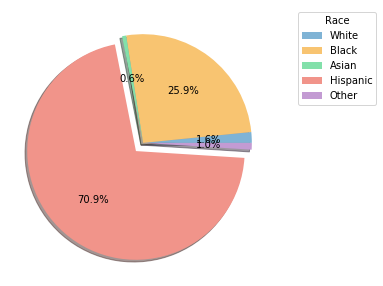

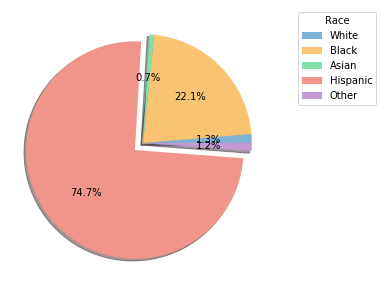

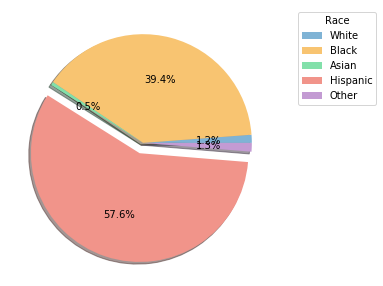

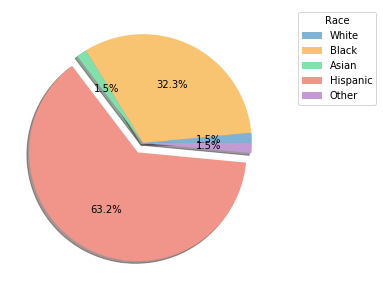

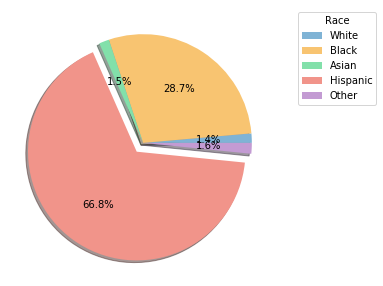

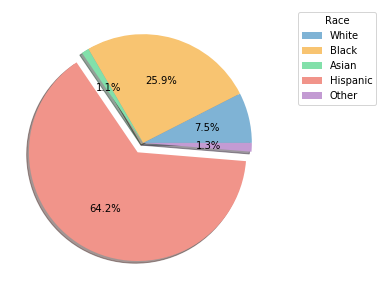

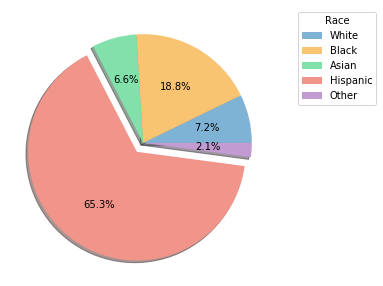

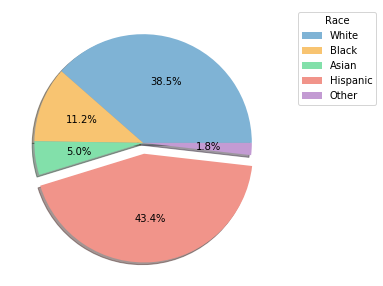

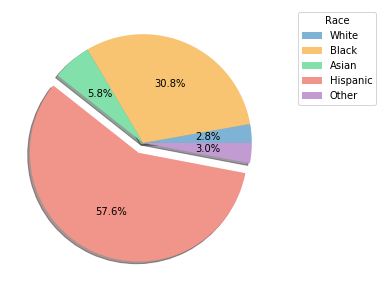

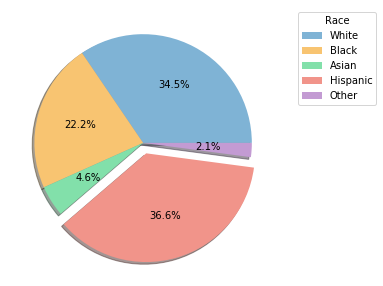

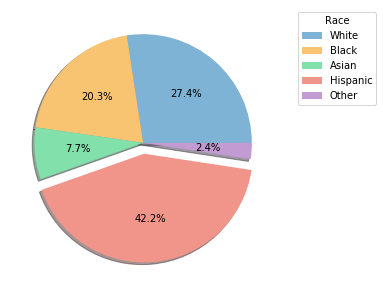

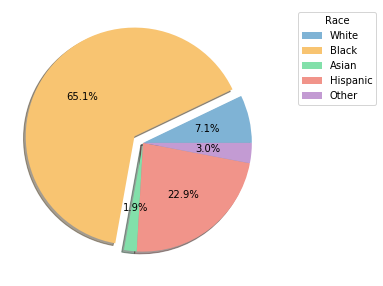

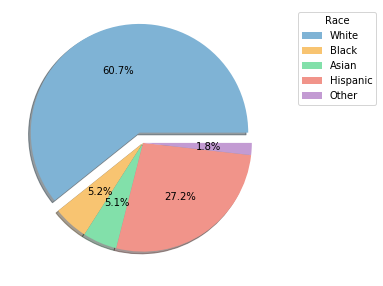

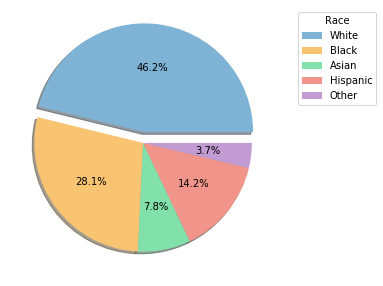

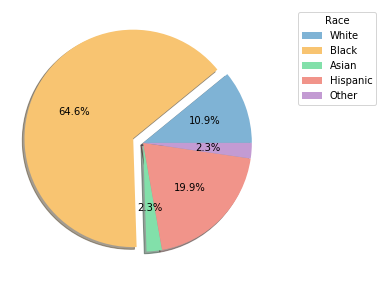

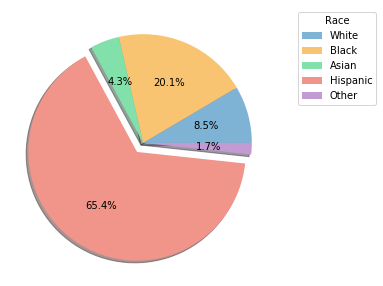

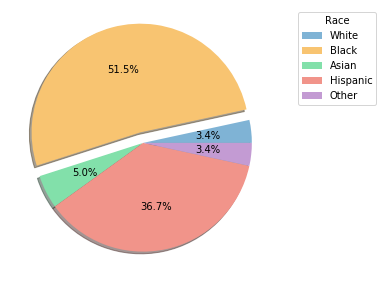

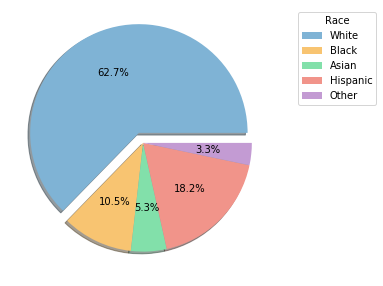

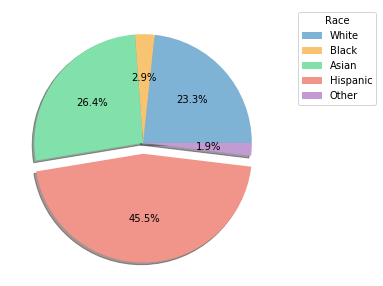

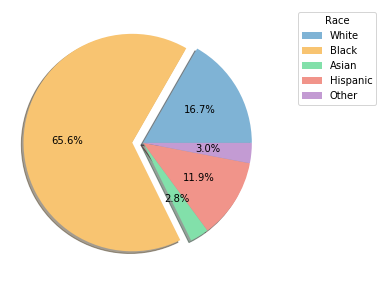

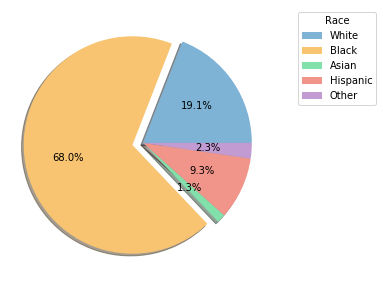

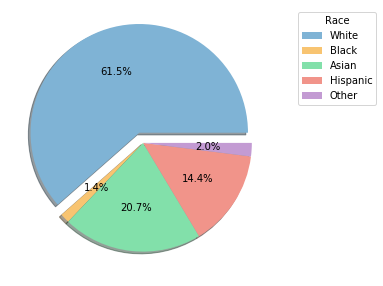

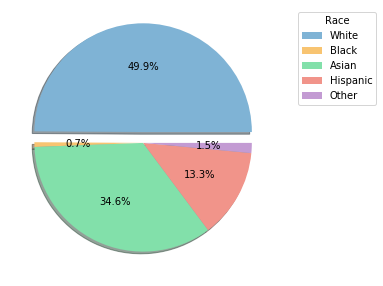

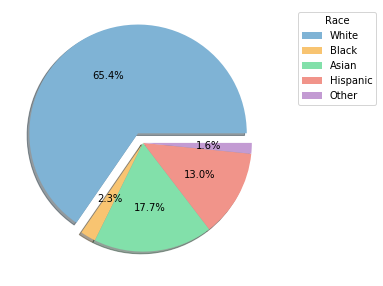

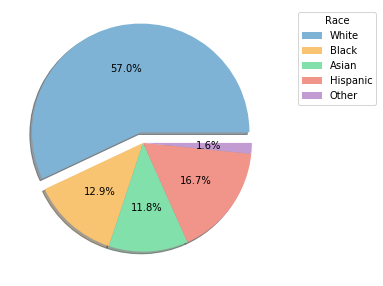

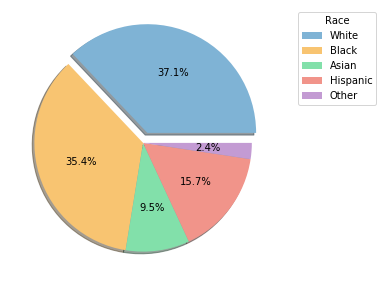

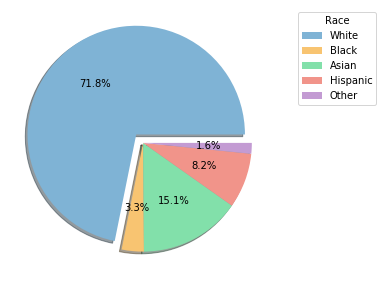

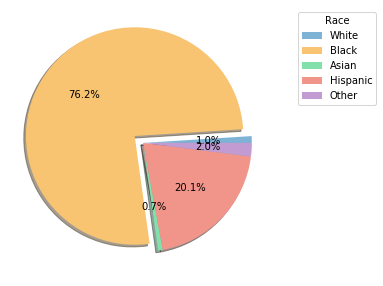

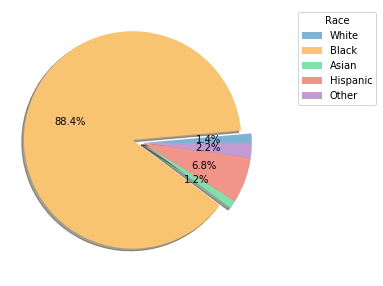

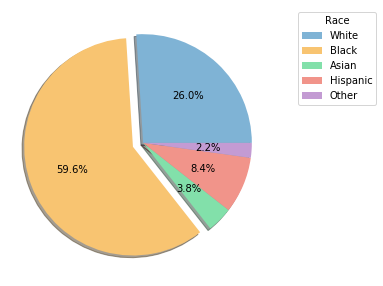

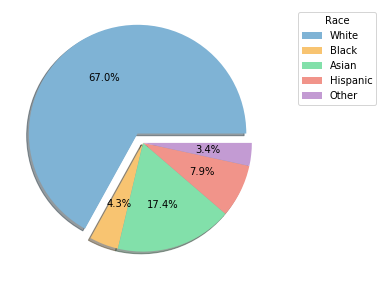

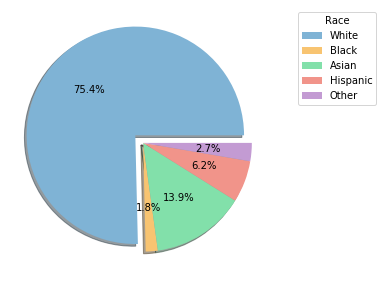

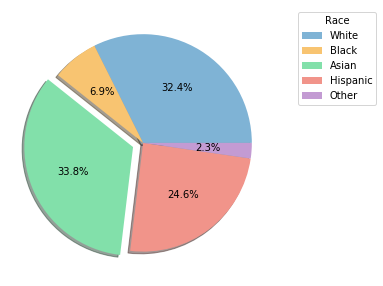

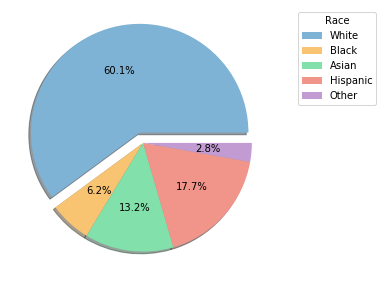

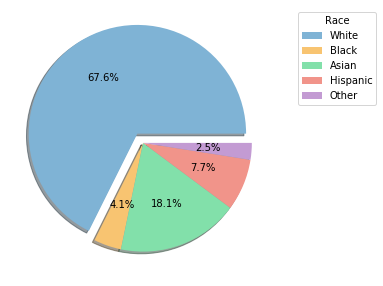

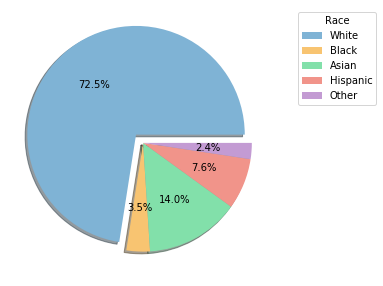

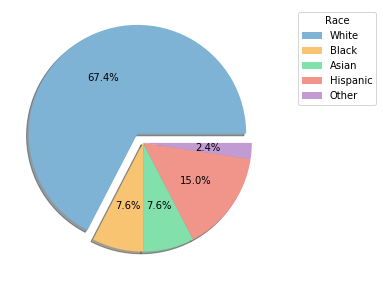

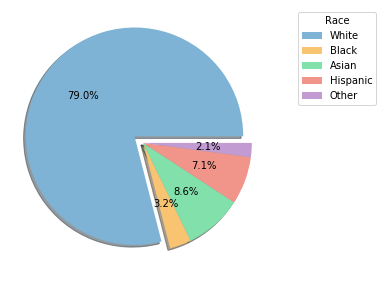

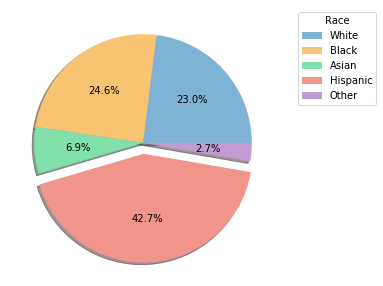

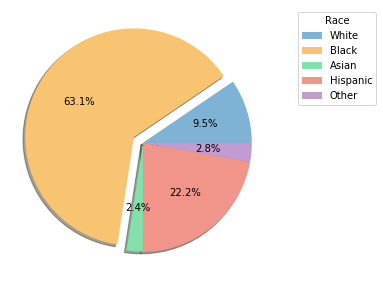

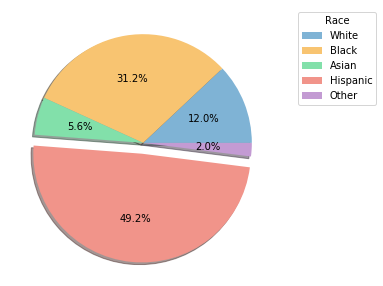

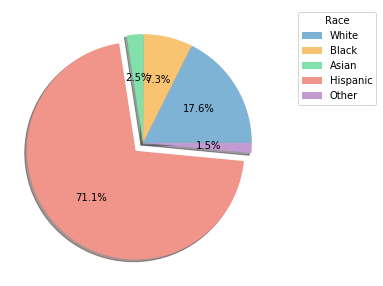

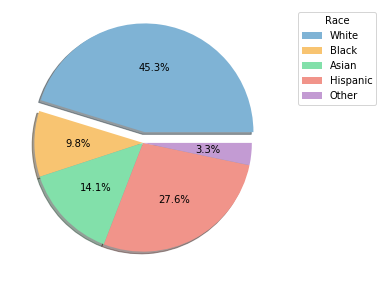

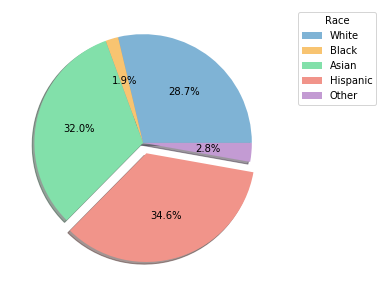

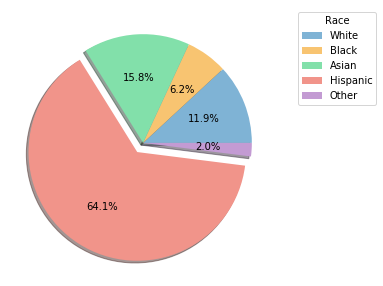

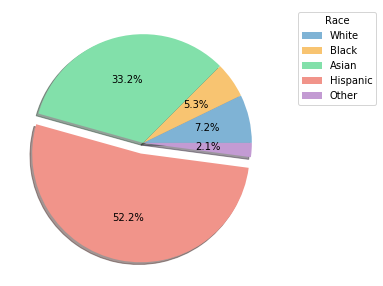

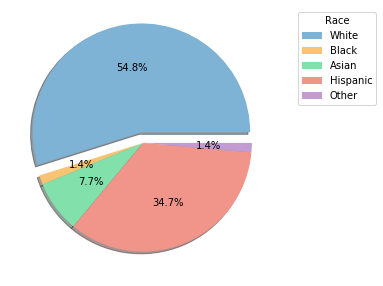

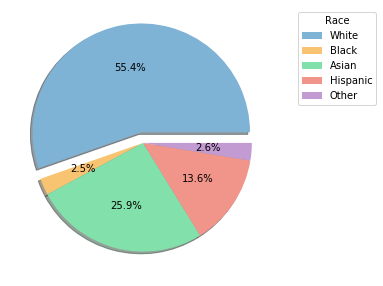

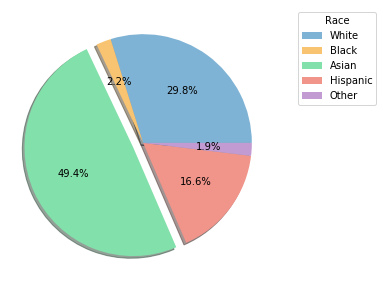

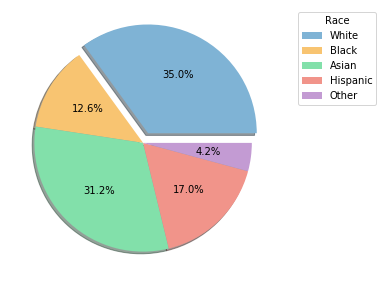

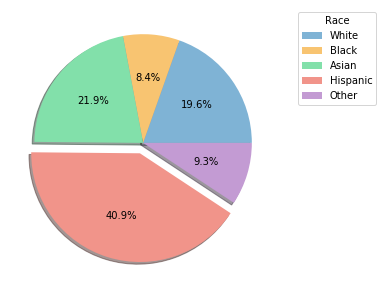

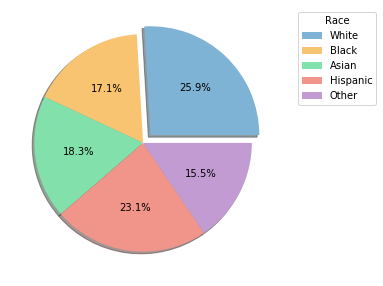

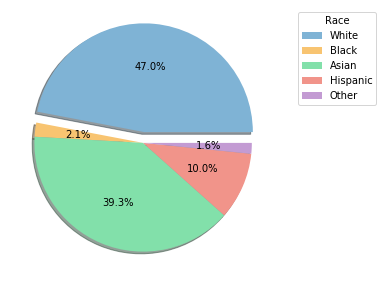

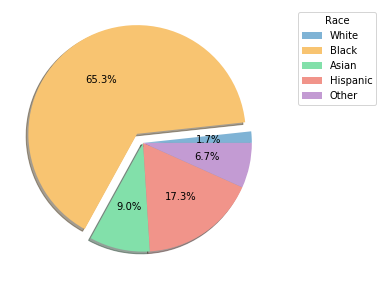

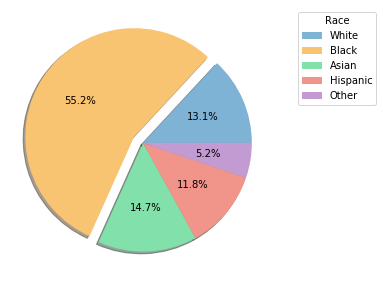

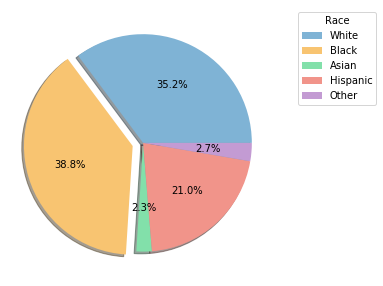

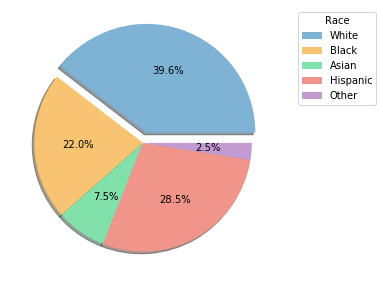

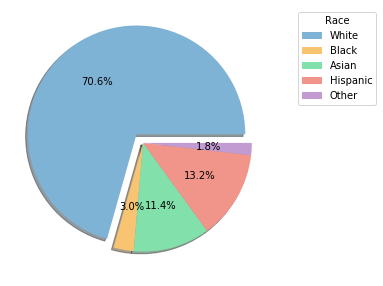

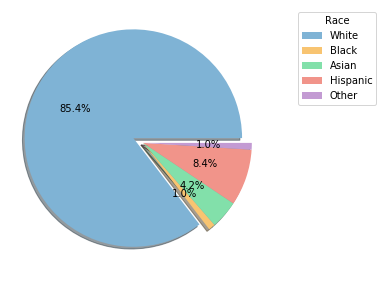

In [31]:
# Breakdown of race per community district

for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["White", "Black", "Asian", "Hispanic", "Other"]
    values = [float(frame_percentages.iloc[i, 1]), float(frame_percentages.iloc[i, 2]), float(frame_percentages.iloc[i, 3]),
              float(frame_percentages.iloc[i, 6]), float(frame_percentages.iloc[i, 4]) + float(frame_percentages.iloc[i, 5])]
    
    explode = (0, 0, 0, 0, 0)
    if max(values) == values[0]:
        explode = (0.1, 0, 0, 0, 0)
    elif max(values) == values[1]:
        explode = (0, 0.1, 0, 0, 0)
    elif max(values) == values[2]:
        explode = (0, 0, 0.1, 0, 0)
    elif max(values) == values[3]:
        explode = (0, 0, 0, 0.1, 0)
    else:
        explode = (0, 0, 0, 0, 0)
    
    colors = ['#7FB3D5', '#F8C471', '#82E0AA', '#F1948A', '#C39BD3']
    plt.pie(values, labels=labels, colors=colors, explode=explode, shadow=True, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Race")
    plt.show()


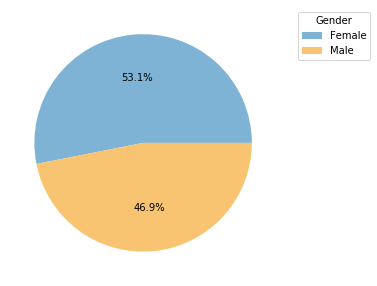

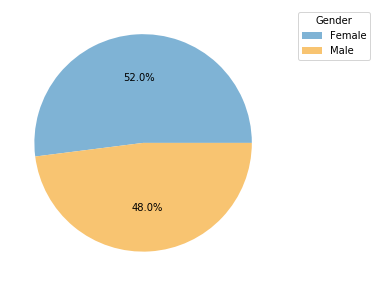

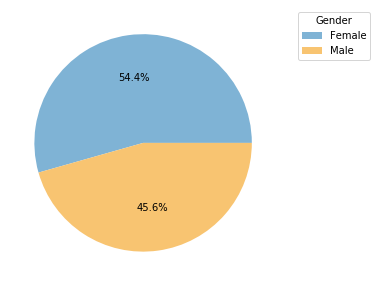

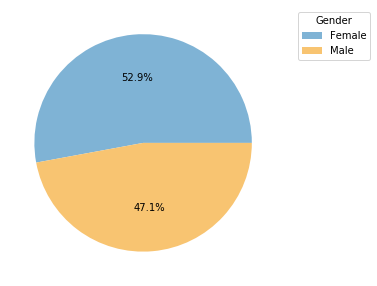

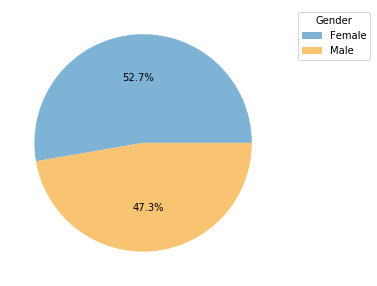

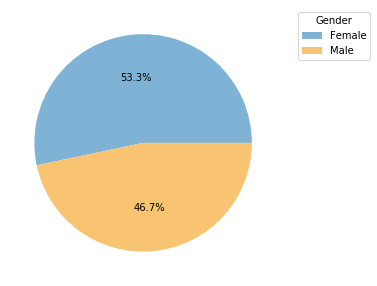

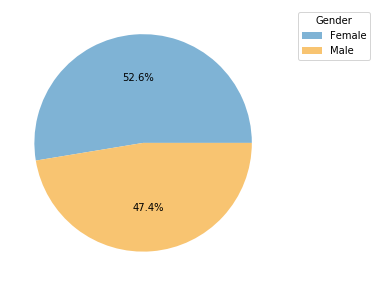

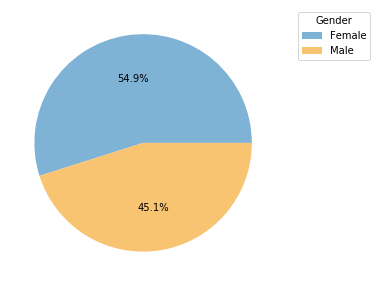

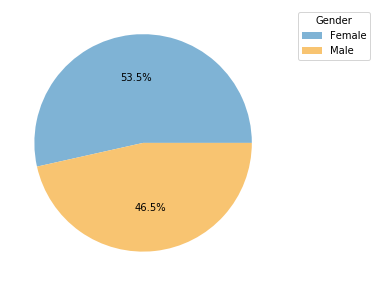

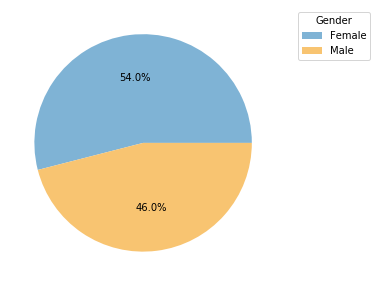

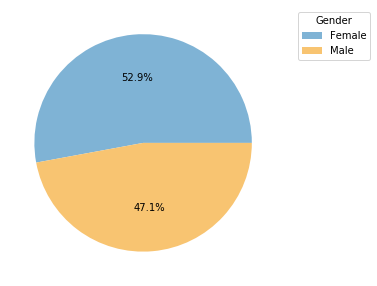

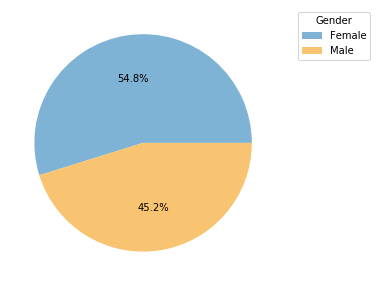

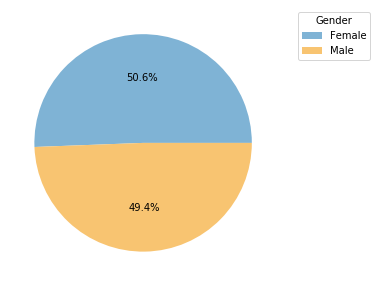

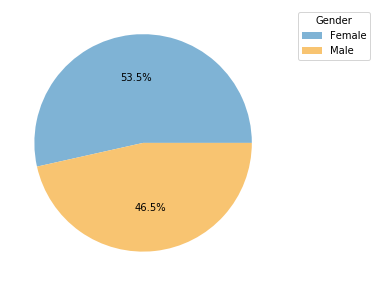

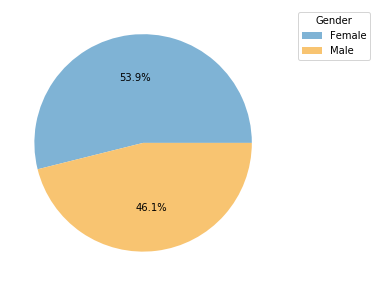

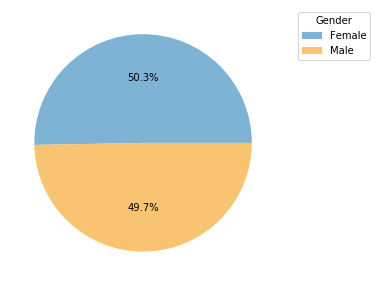

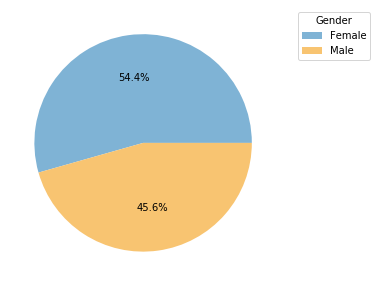

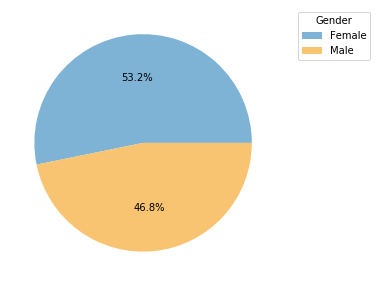

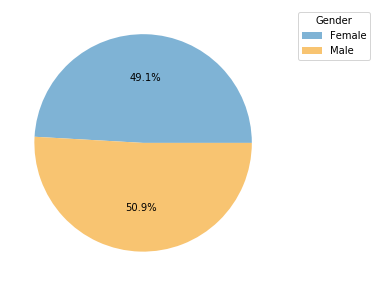

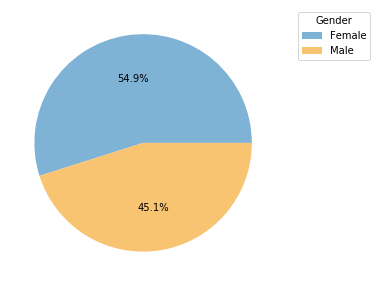

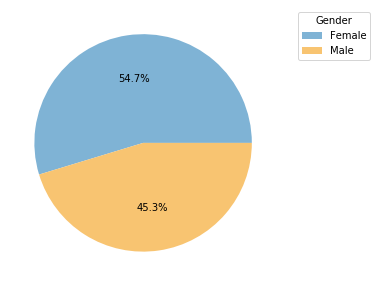

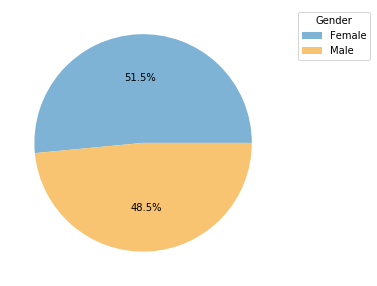

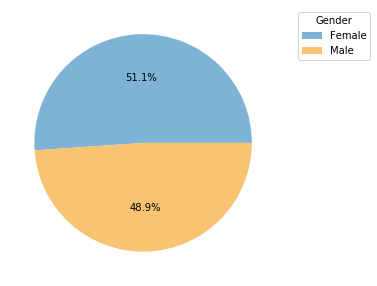

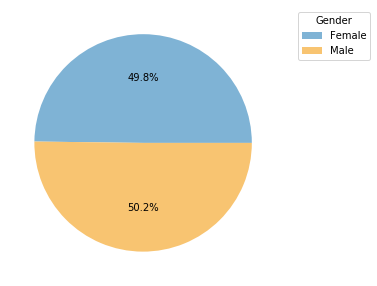

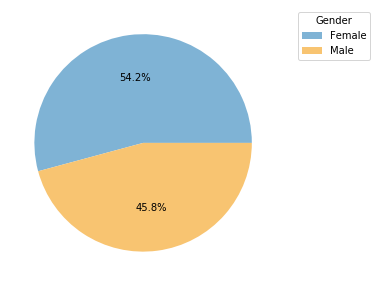

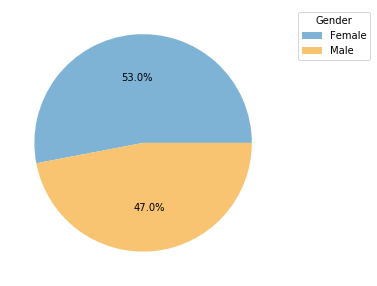

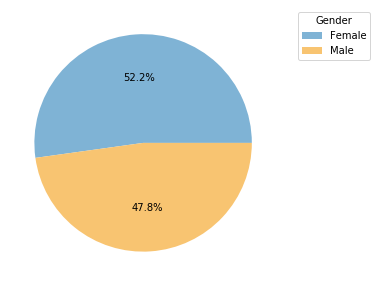

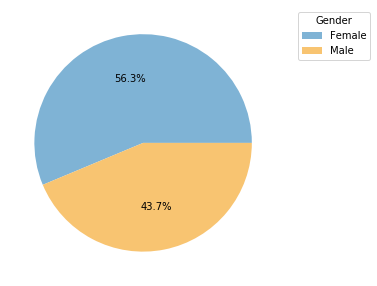

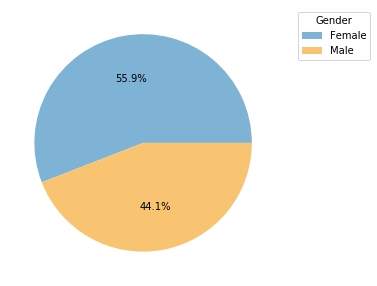

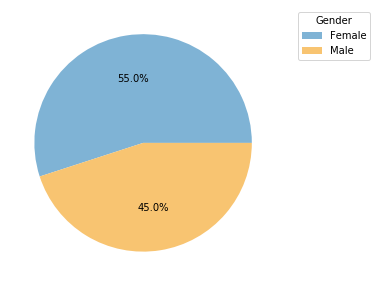

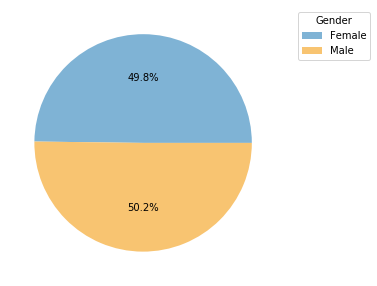

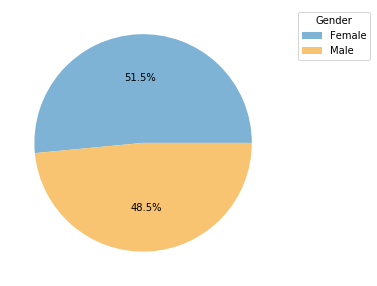

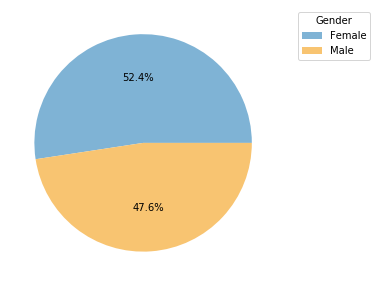

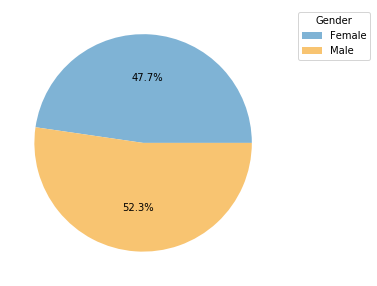

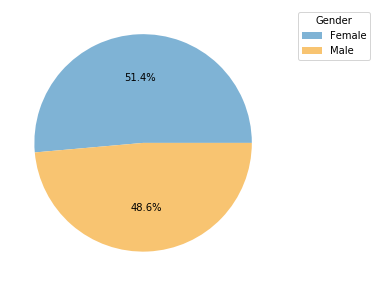

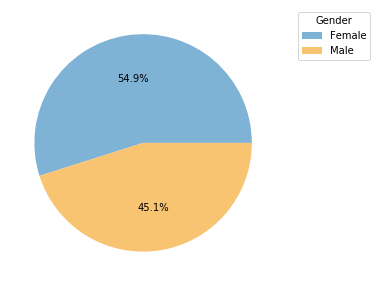

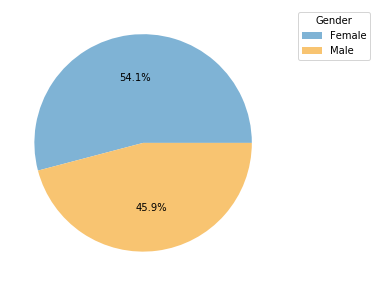

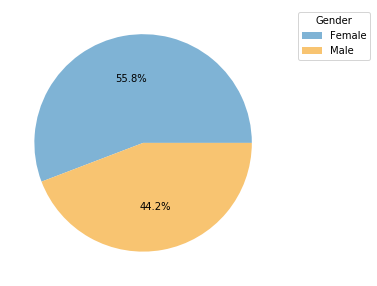

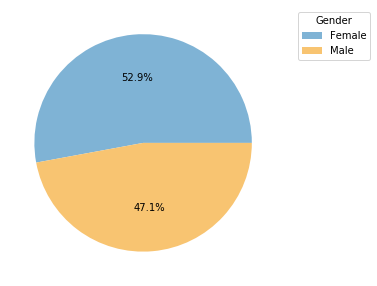

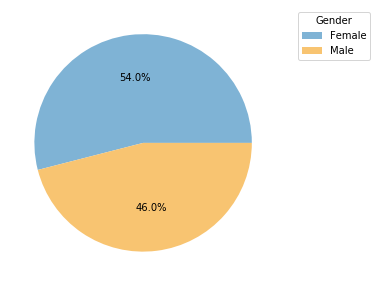

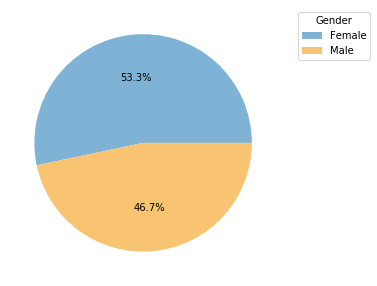

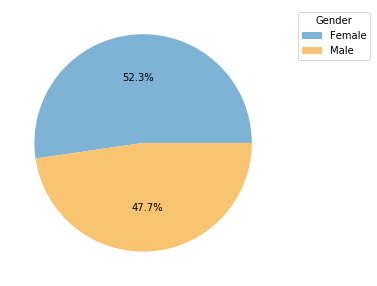

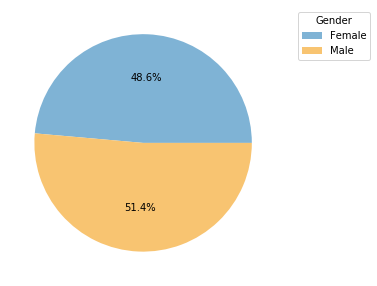

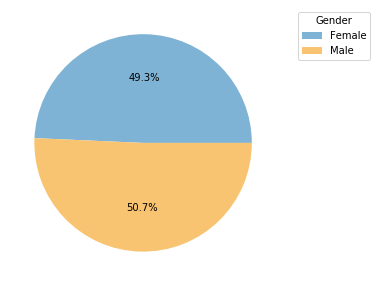

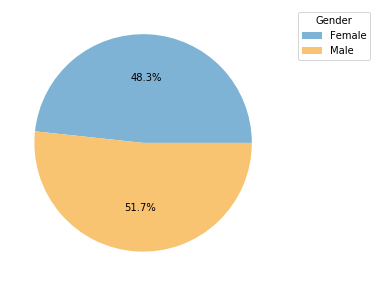

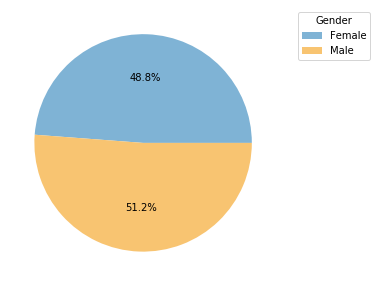

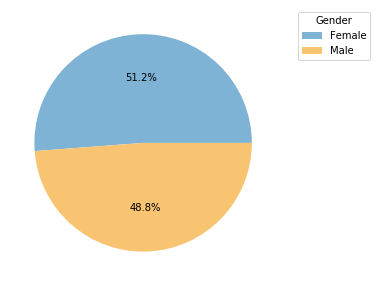

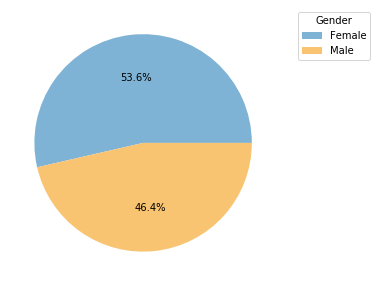

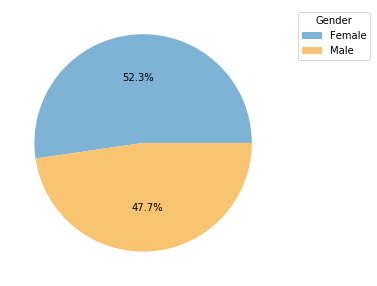

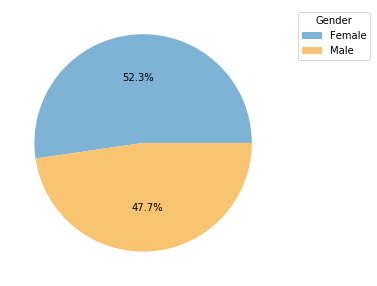

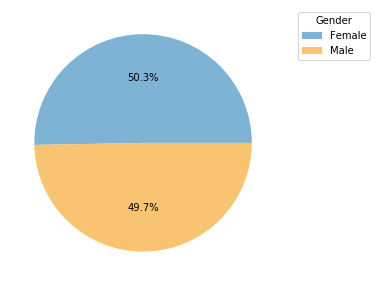

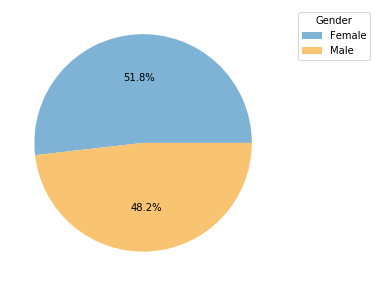

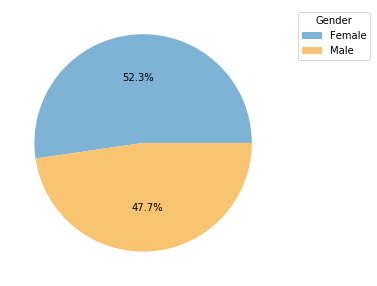

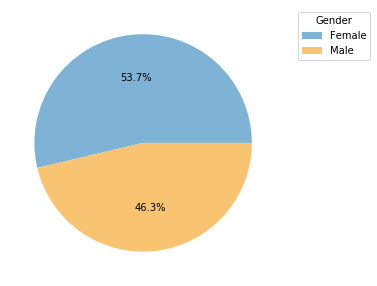

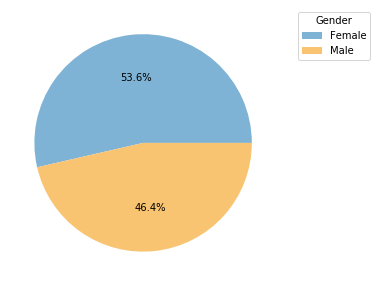

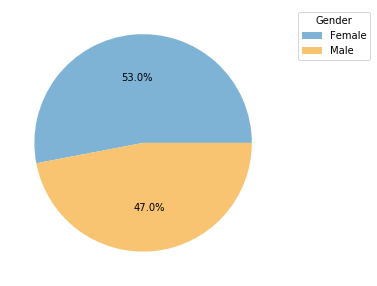

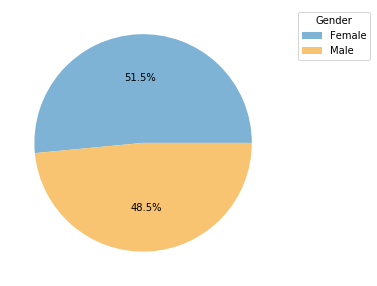

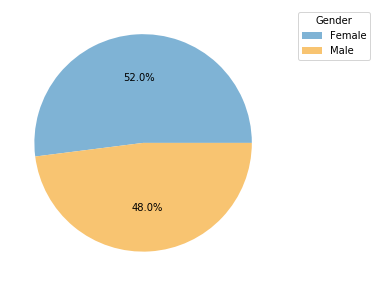

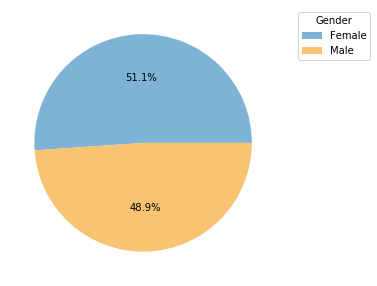

In [32]:
# Gender per community district

for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["Female", "Male"]
    values = [frame_percentages.iloc[i, 7], frame_percentages.iloc[i, 8]]
    
    colors = ['#7FB3D5', '#F8C471']
    plt.pie(values, labels=labels, colors=colors, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Gender")
    plt.show()

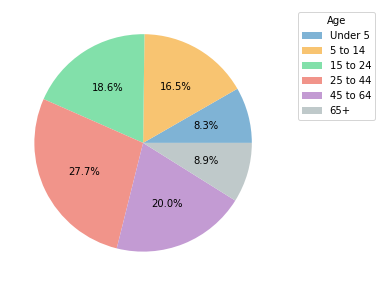

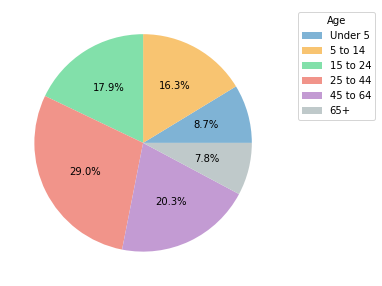

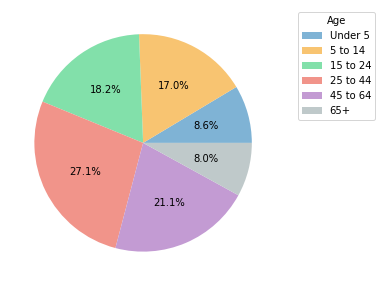

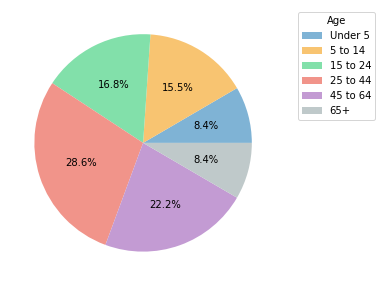

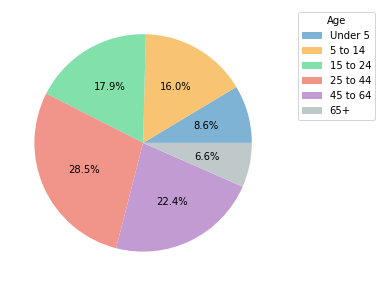

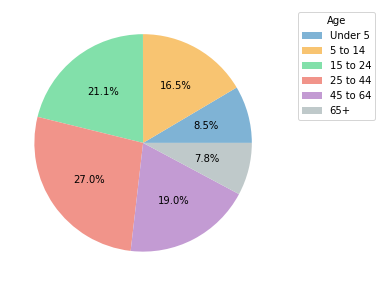

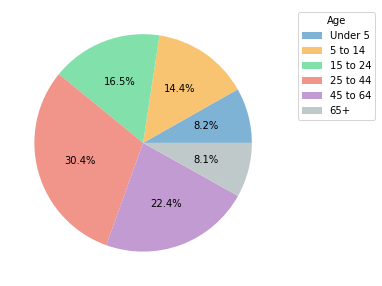

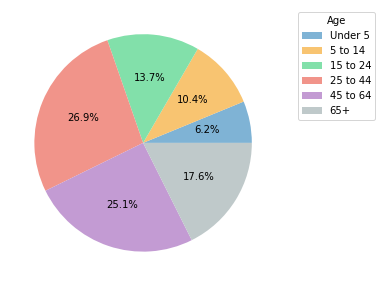

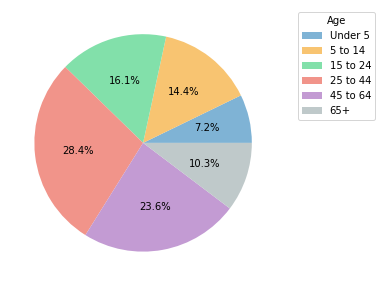

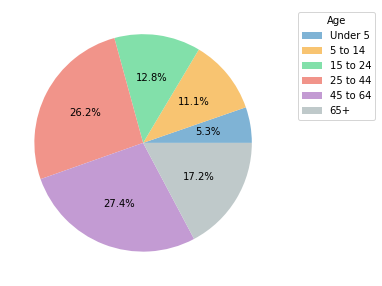

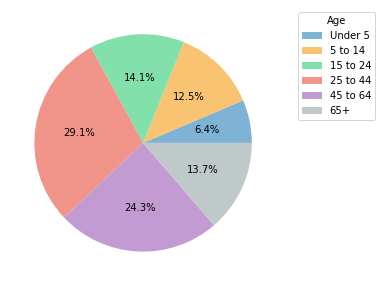

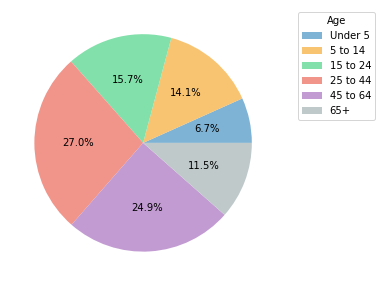

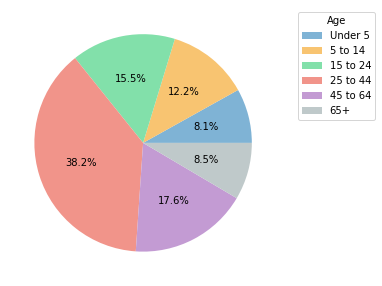

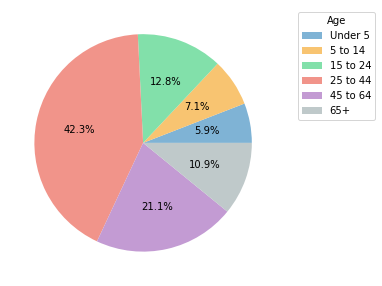

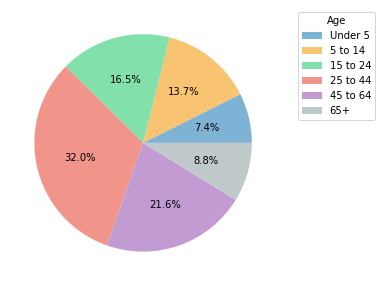

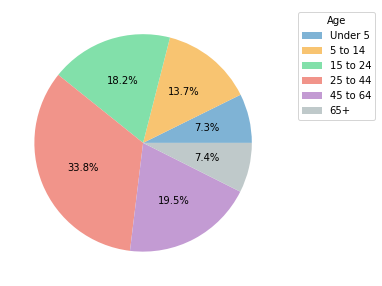

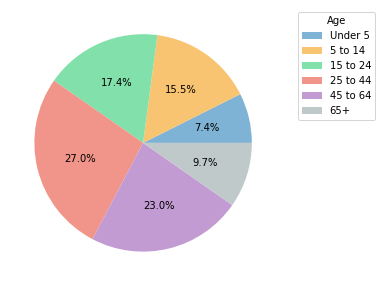

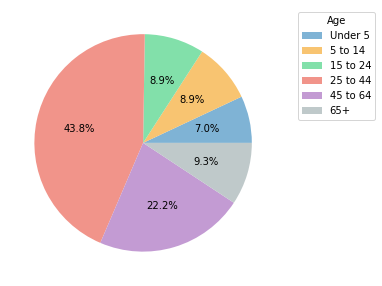

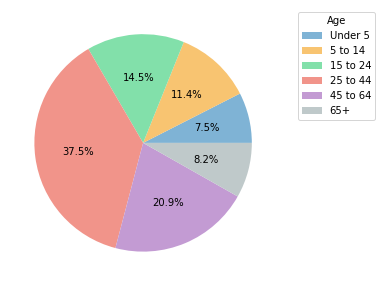

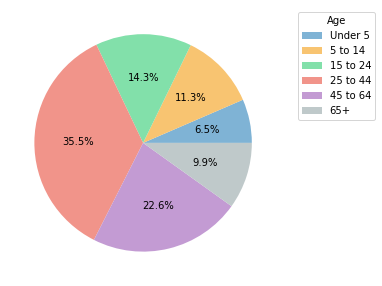

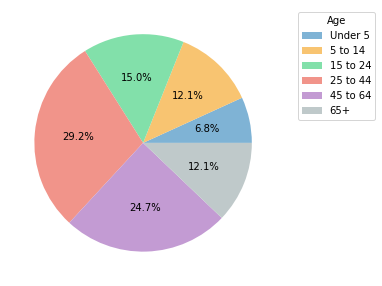

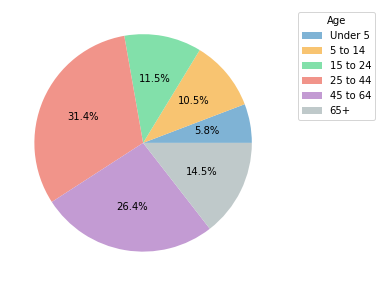

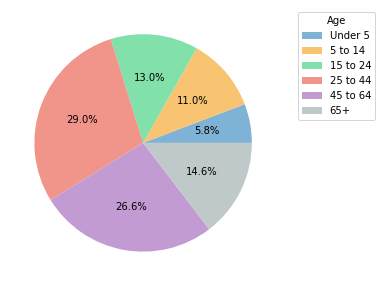

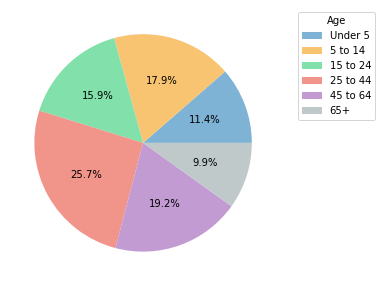

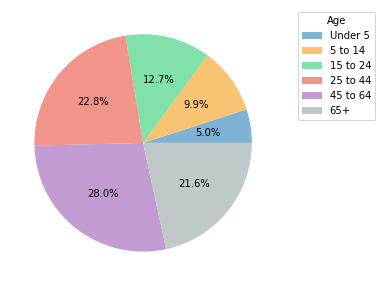

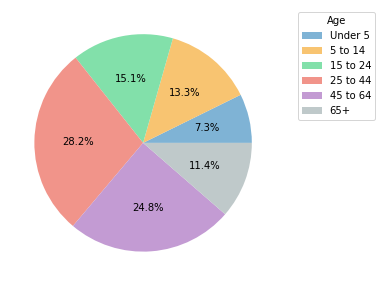

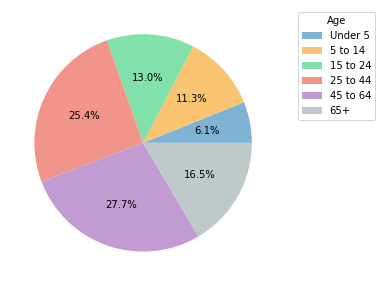

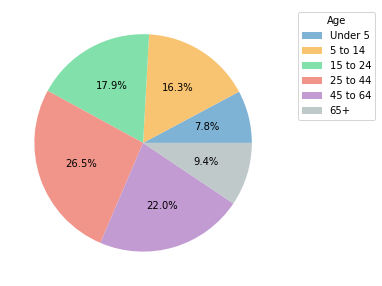

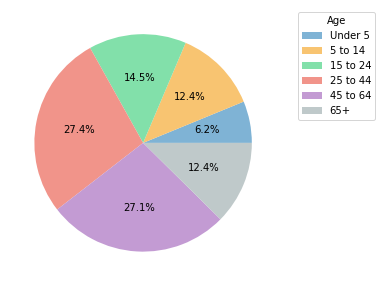

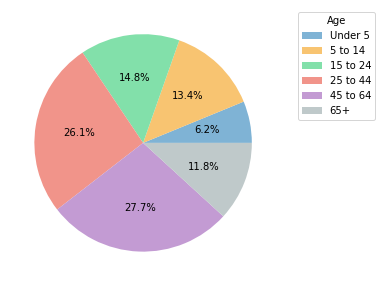

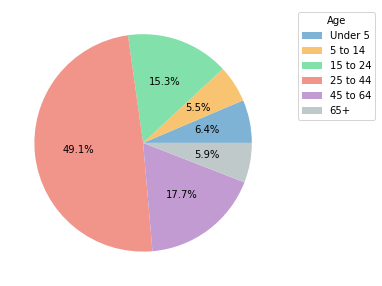

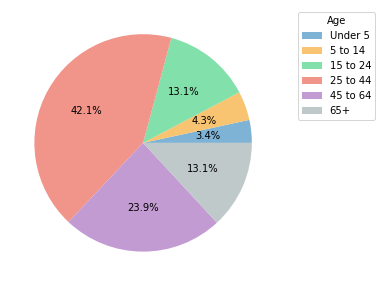

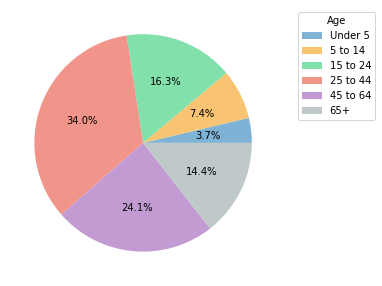

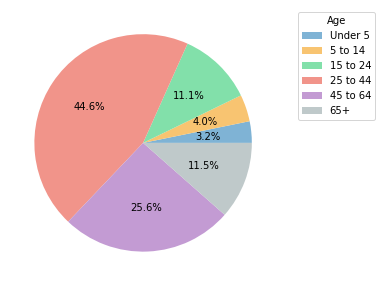

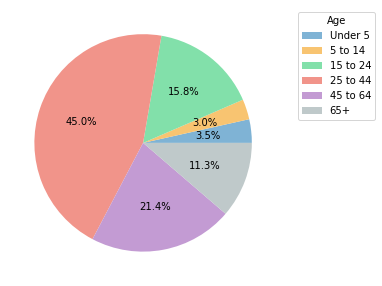

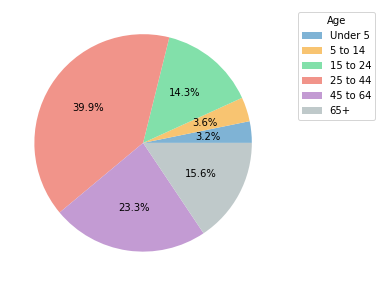

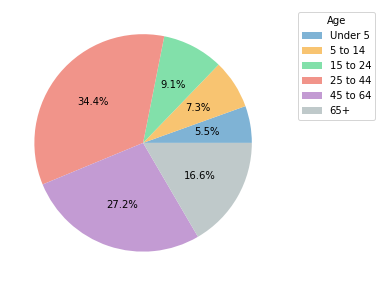

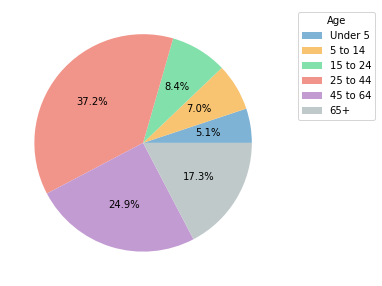

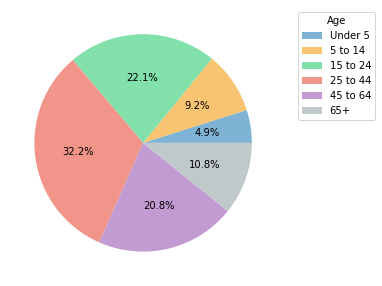

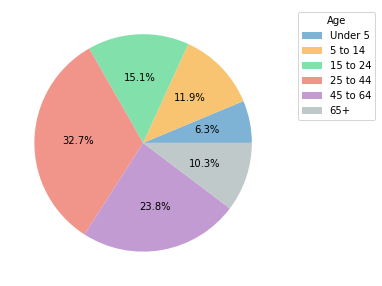

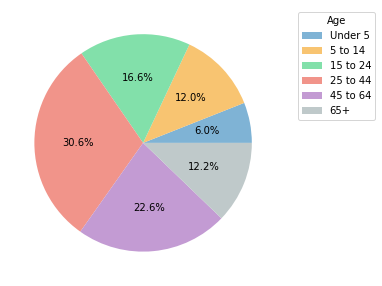

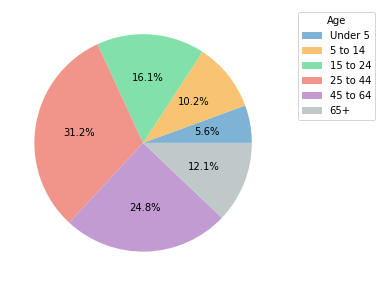

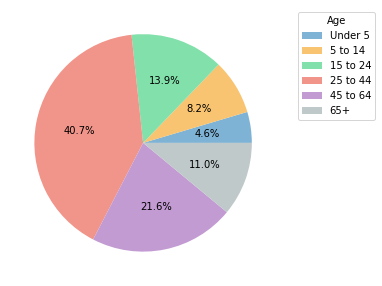

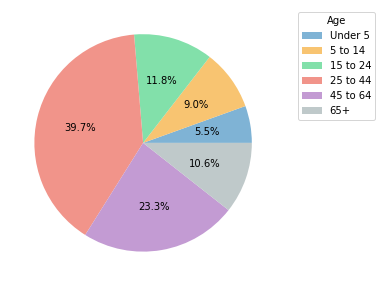

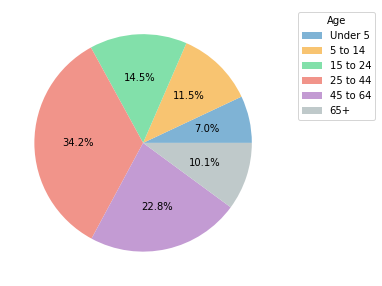

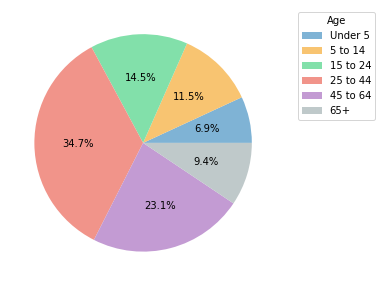

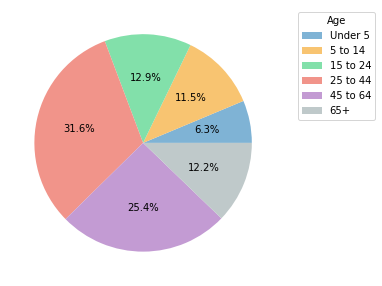

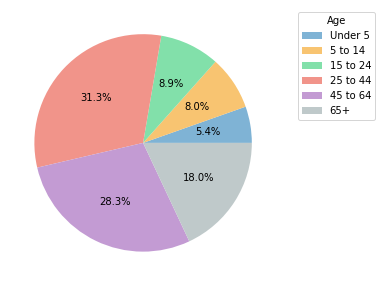

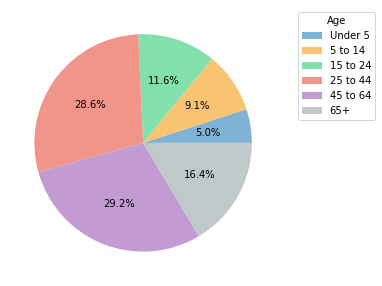

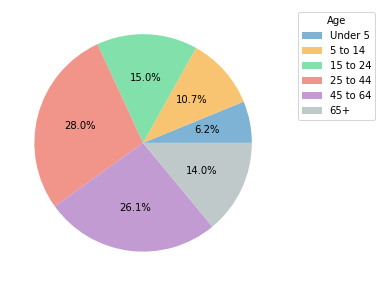

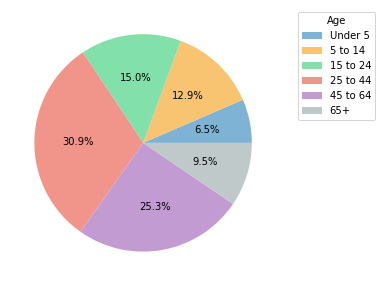

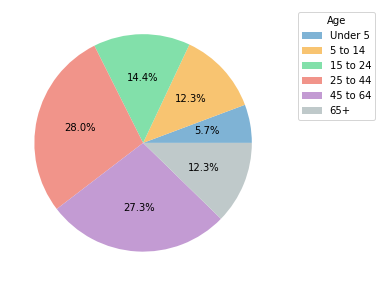

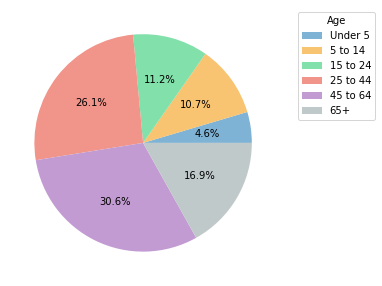

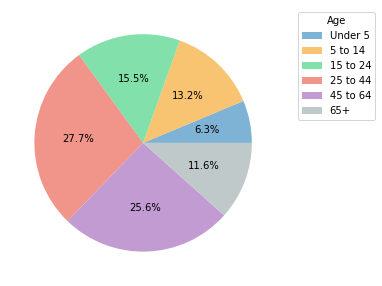

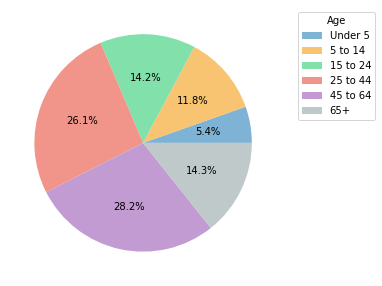

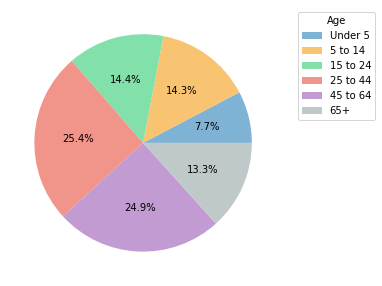

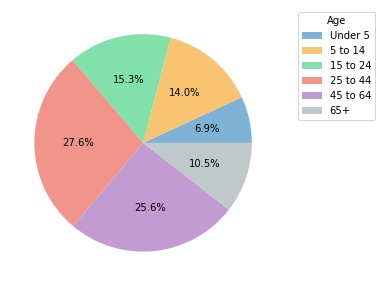

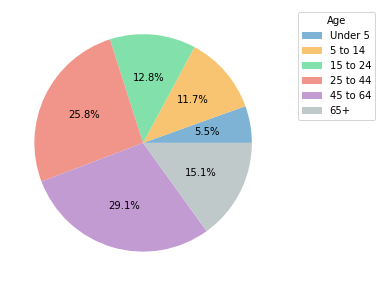

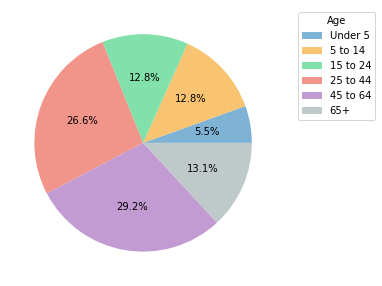

In [33]:
# Age per community district

for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["Under 5", "5 to 14", "15 to 24", "25 to 44", "45 to 64", "65+"]
    values = [float(frame_percentages.iloc[i, 9]), float(frame_percentages.iloc[i, 10]) + float(frame_percentages.iloc[i, 11]), 
              float(frame_percentages.iloc[i, 12]) + float(frame_percentages.iloc[i, 13]), float(frame_percentages.iloc[i, 14]),
              float(frame_percentages.iloc[i, 15]), float(frame_percentages.iloc[i, 16])]
    
    colors = ['#7FB3D5', '#F8C471', '#82E0AA', '#F1948A', '#C39BD3', '#BFC9CA']
    plt.pie(values, labels=labels, colors=colors, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Age")
    plt.show()

/Users/beccadorn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


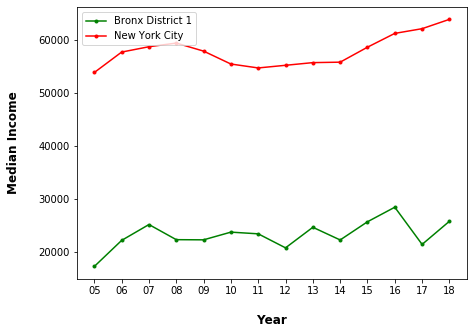

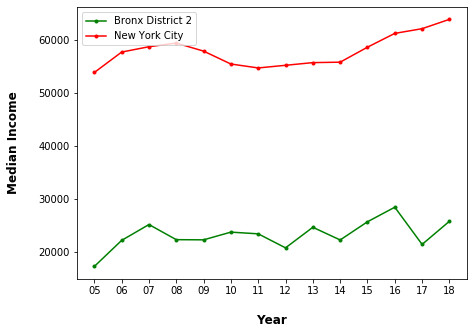

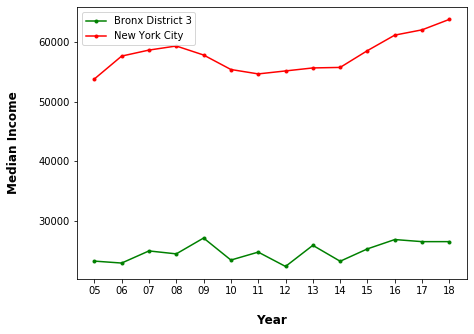

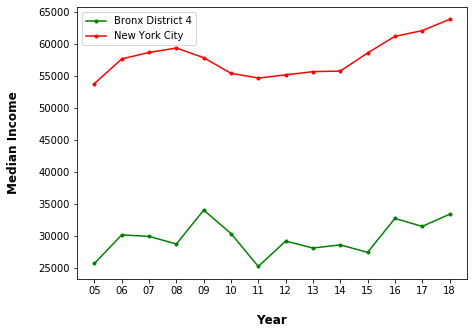

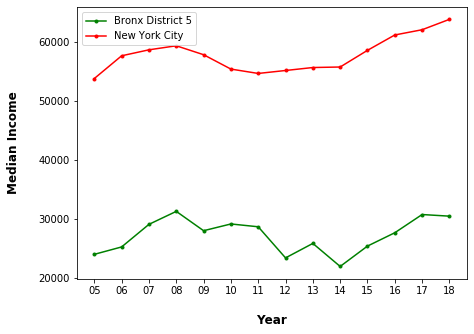

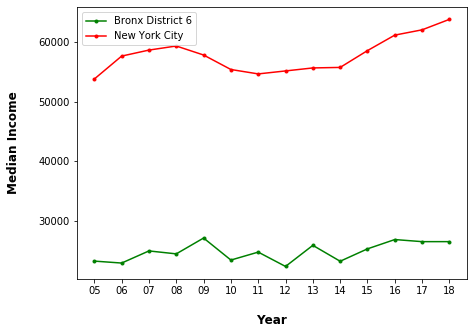

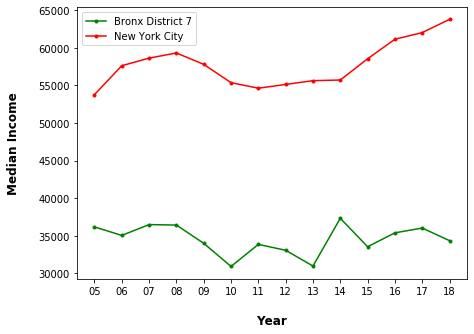

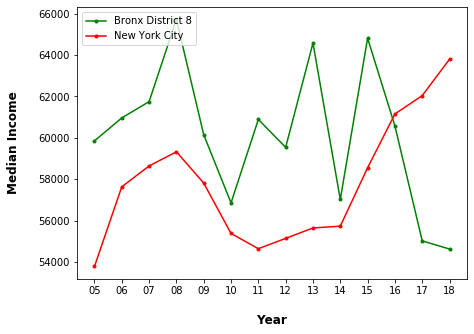

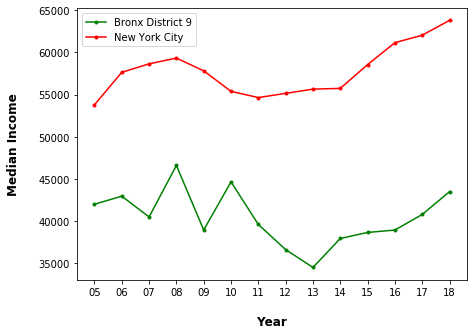

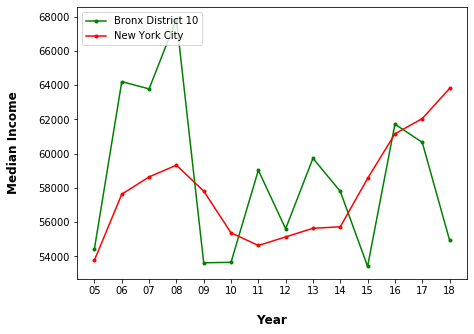

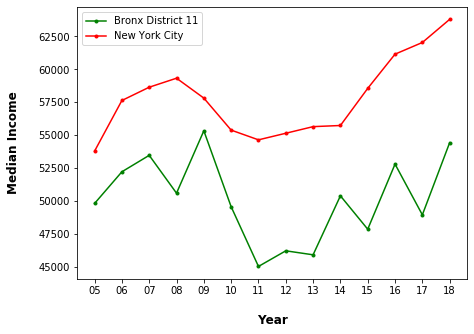

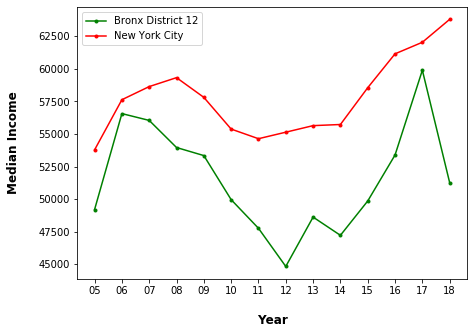

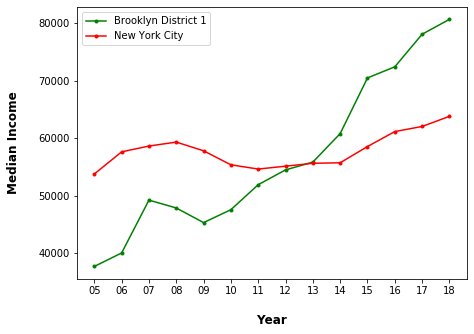

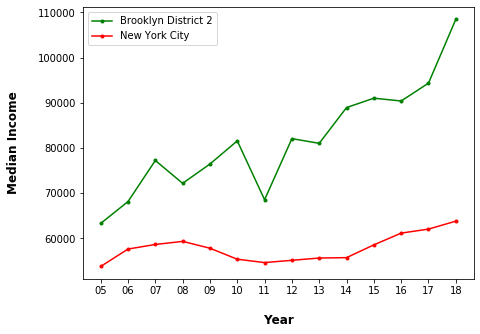

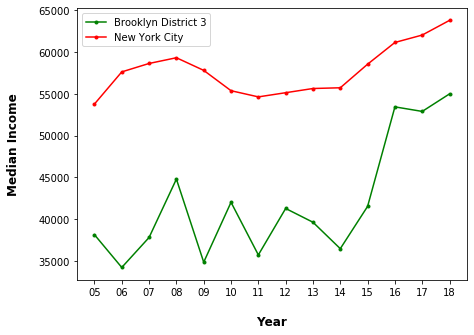

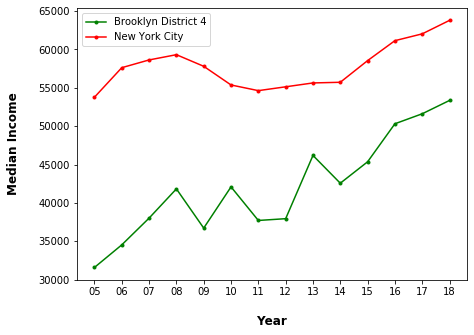

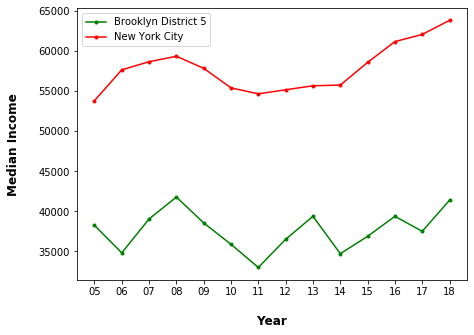

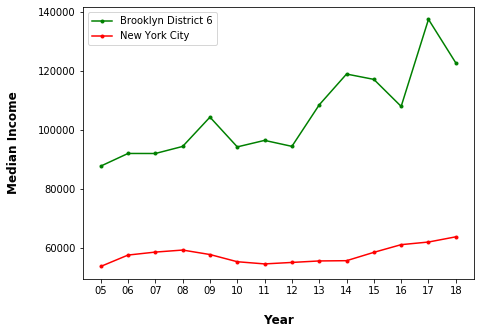

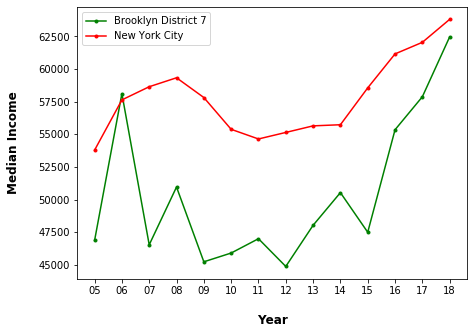

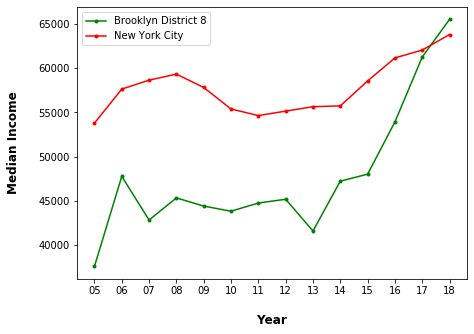

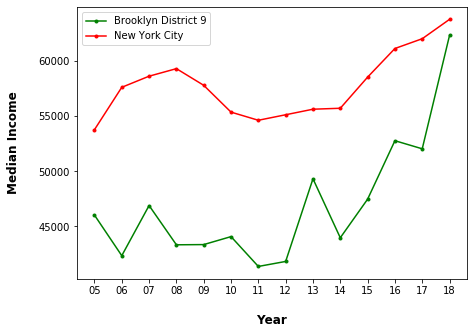

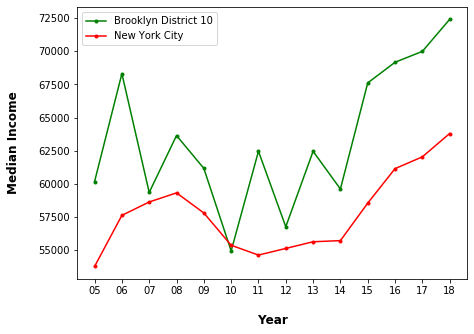

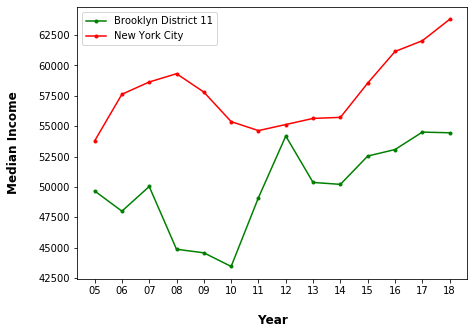

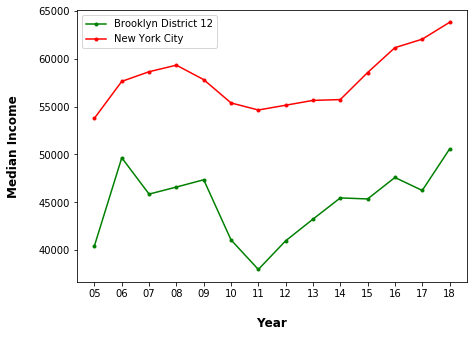

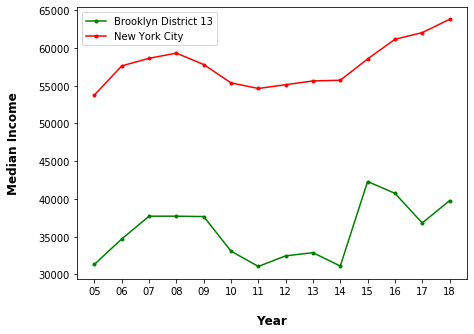

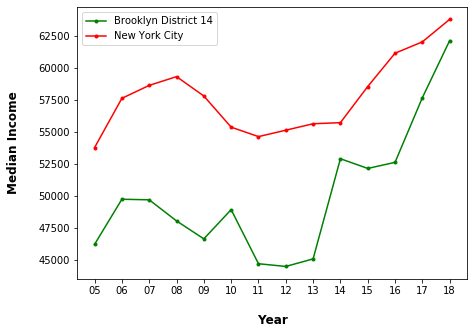

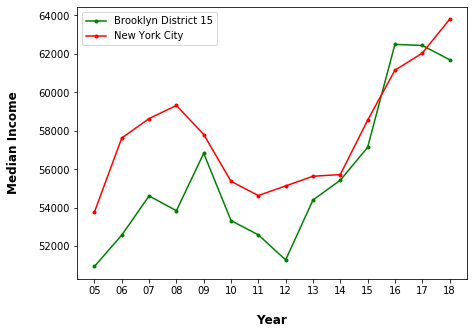

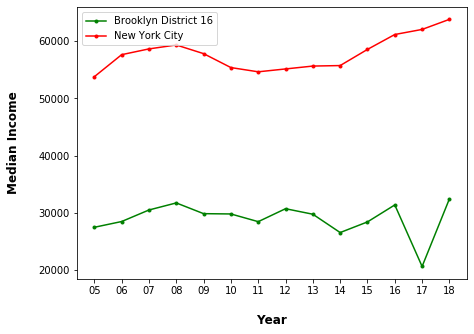

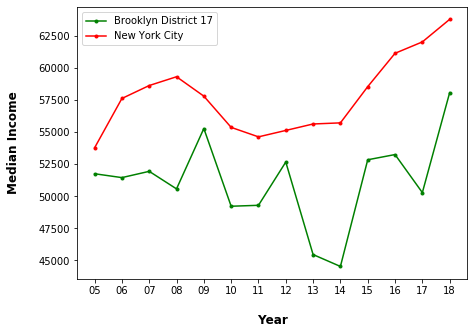

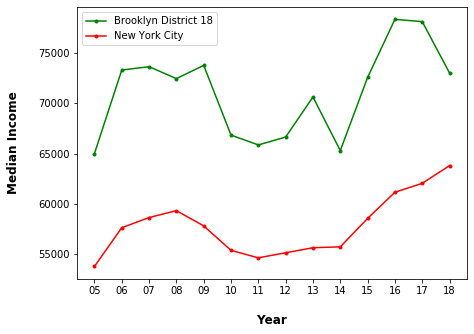

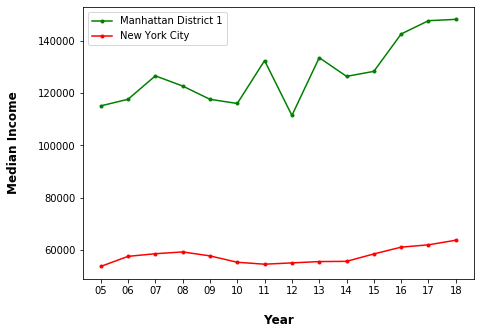

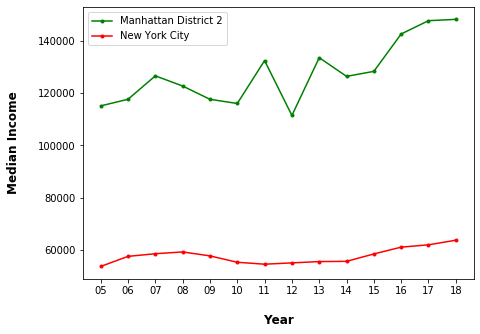

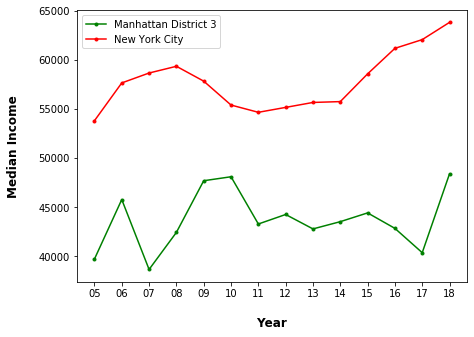

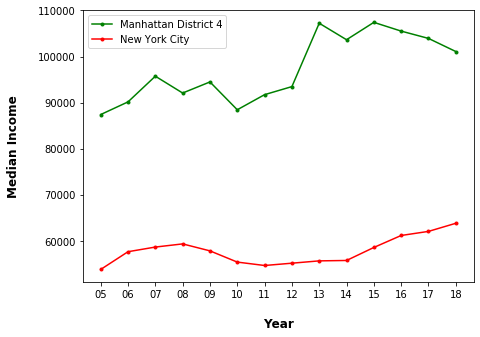

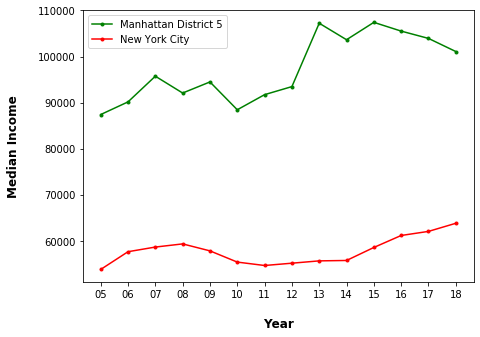

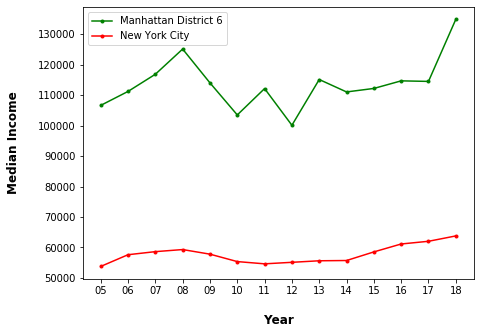

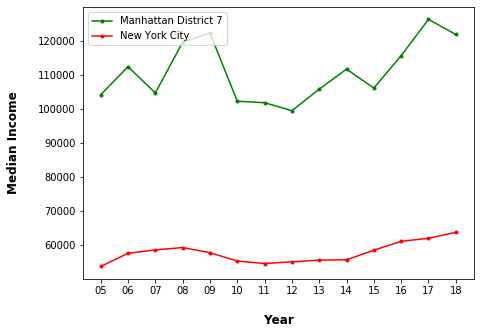

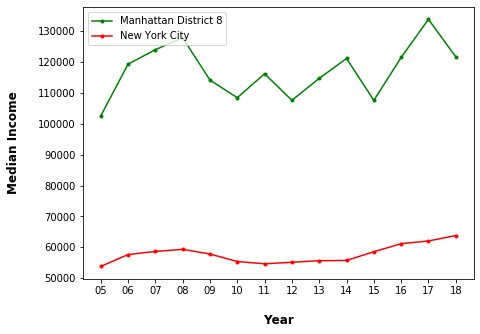

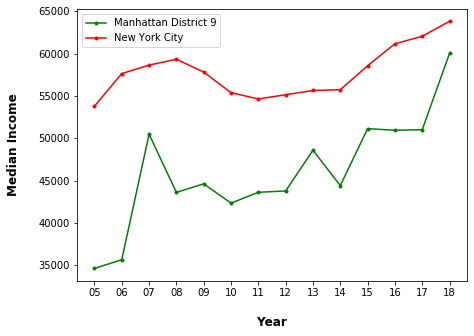

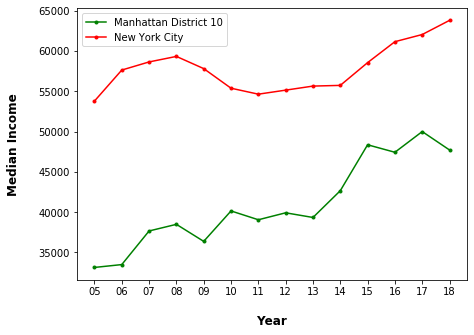

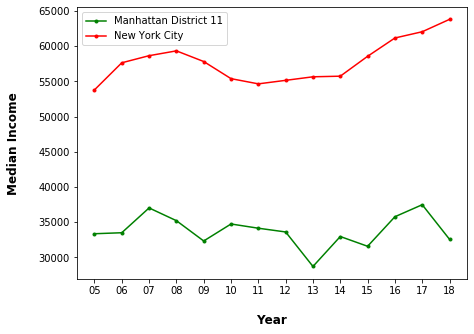

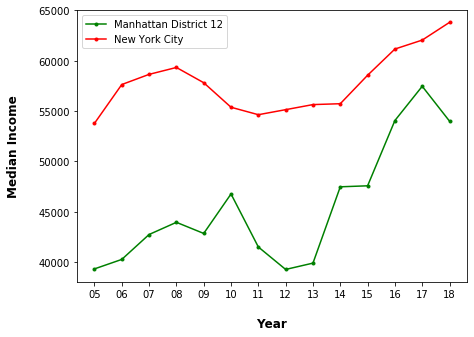

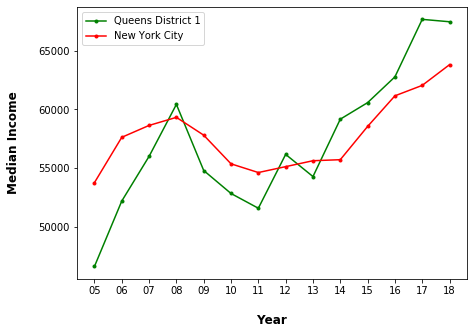

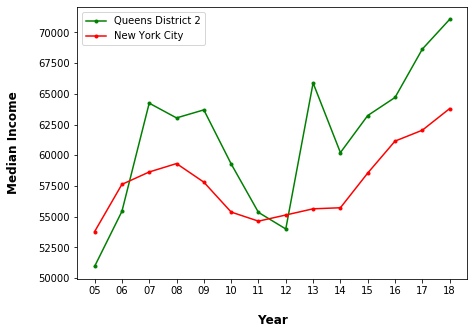

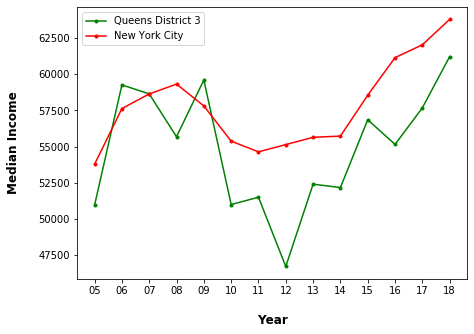

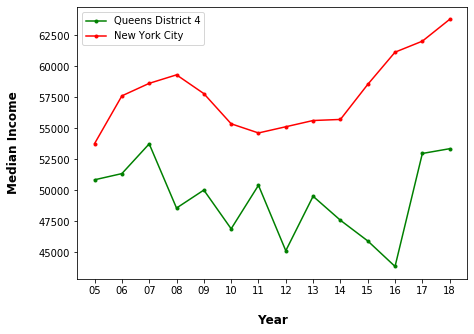

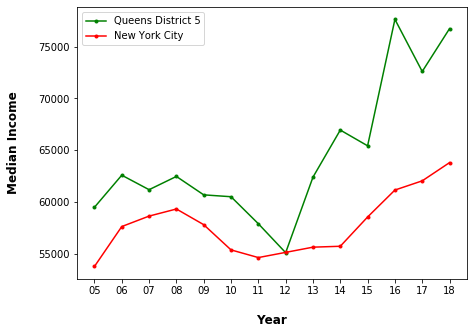

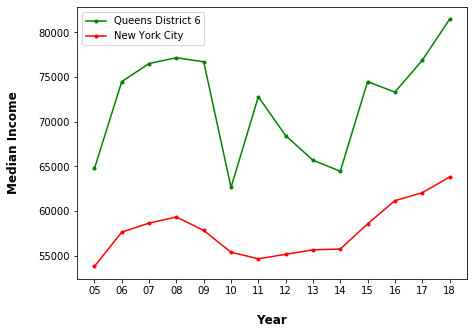

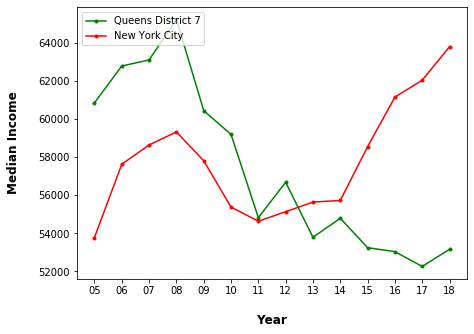

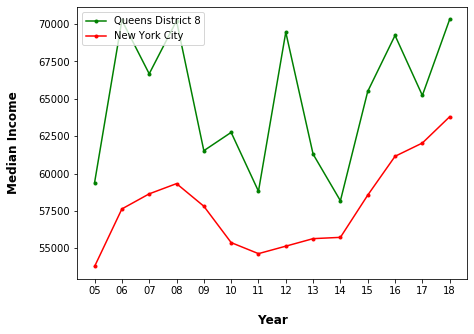

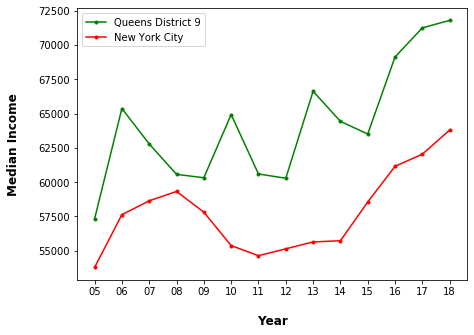

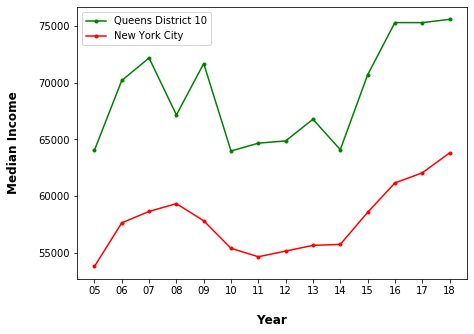

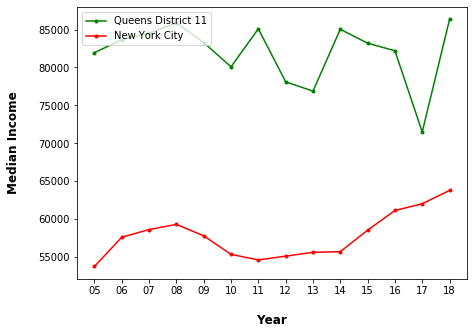

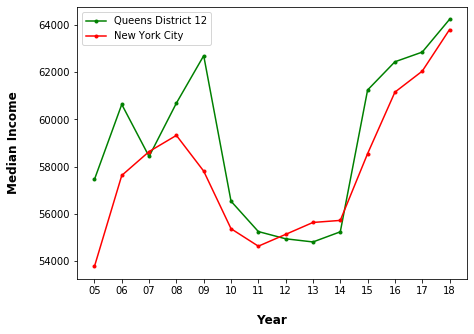

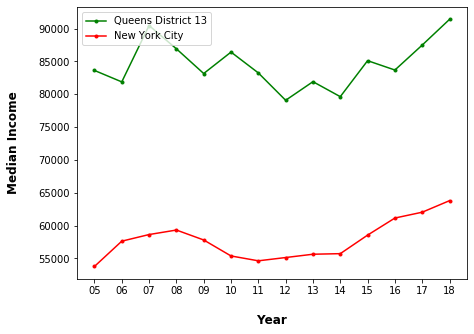

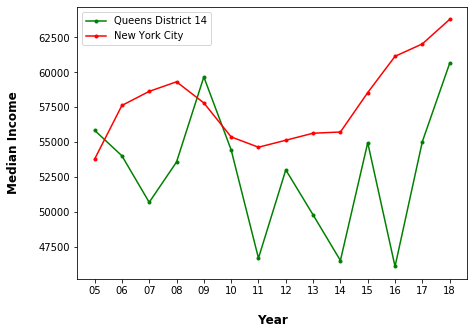

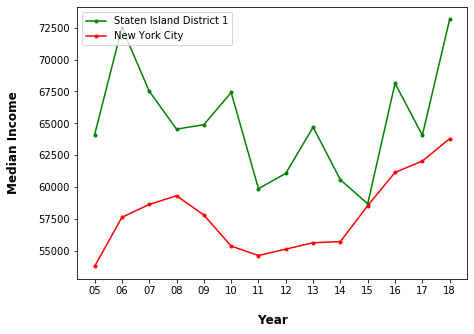

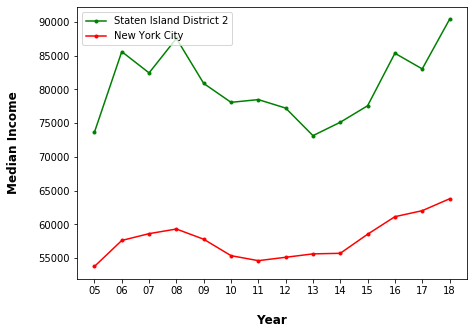

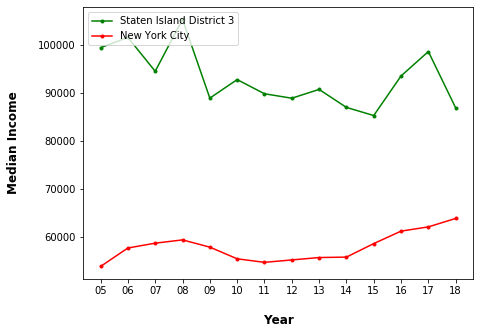

In [34]:
#Comparing median household income of NYC and each community district from 2005-2018 

district_labels = ['Bronx District 1', 'Bronx District 2', 'Bronx District 3', 'Bronx District 4', 'Bronx District 5', 'Bronx District 6', 
                   'Bronx District 7', 'Bronx District 8', 'Bronx District 9', 'Bronx District 10', 'Bronx District 11', 'Bronx District 12', 
                   'Brooklyn District 1', 'Brooklyn District 2', 'Brooklyn District 3', 'Brooklyn District 4', 'Brooklyn District 5', 'Brooklyn District 6', 
                   'Brooklyn District 7', 'Brooklyn District 8', 'Brooklyn District 9', 'Brooklyn District 10', 'Brooklyn District 11', 'Brooklyn District 12', 
                   'Brooklyn District 13', 'Brooklyn District 14', 'Brooklyn District 15', 'Brooklyn District 16', 'Brooklyn District 17', 'Brooklyn District 18',
                   'Manhattan District 1', 'Manhattan District 2', 'Manhattan District 3', 'Manhattan District 4', 'Manhattan District 5', 'Manhattan District 6', 
                   'Manhattan District 7', 'Manhattan District 8', 'Manhattan District 9', 'Manhattan District 10', 'Manhattan District 11', 'Manhattan District 12', 
                   'Queens District 1', 'Queens District 2', 'Queens District 3', 'Queens District 4', 'Queens District 5', 'Queens District 6', 'Queens District 7',
                   'Queens District 8', 'Queens District 9', 'Queens District 10', 'Queens District 11', 'Queens District 12', 'Queens District 13', 'Queens District 14', 
                   'Staten Island District 1', 'Staten Island District 2', 'Staten Island District 3']

for i in range(0, 59):
    plt.figure(figsize=(7, 5))
    plt.plot(household_income.iloc[i].index, household_income.iloc[i].values,'g.-', label=district_labels[i])
    plt.plot(nyc_household_income.iloc[0].index, nyc_household_income.iloc[0].values,'r.-', label='New York City')
    plt.legend(loc='upper left')
    
    plt.xlabel('Year', fontweight='bold', labelpad=18, fontsize=12)
    plt.ylabel('Median Income', fontweight='bold', labelpad=18, fontsize=12)


# Sources:
https://nyc.streetsblog.org/2019/11/14/mta-will-spend-249m-on-new-cops-to-save-200m-on-fare-evasion/ , defining disparate impact
*These are really really not finished*